# NOTE: Outdated Pipeline

In [ ]:
# from google.colab import drive
# import sys
# import warnings


# # Mount Google Drive
# drive.mount('/content/drive', force_remount=True)

# # Get the absolute path of the current folder
# abspath_curr = '/content/drive/My Drive/Colab Notebooks/Depth Duration Analysis/'

# # Ignore warnings
# warnings.filterwarnings('ignore')

# # Change working directory to the absolute path of the shallow utilities folder
# %cd $abspath_curr

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 


In [2]:

def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
            input_data.at[idx, 'unitSelection'] = 'meters'

        
    
    return input_data

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = getUnitConveredData(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(256 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
#     print("Participants with 10% or more missed trials: ", remove_ids)

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)
    
    return input_data



def durationDfs(datafolder):
    """
    Seperate the the data into seperate dataframes for each duration condition
    """
    
    cleaned_data = removeMissedTrials(datafolder)
    
    data_250ms = cleaned_data[cleaned_data['duration'] == 250.0]
    data_500ms = cleaned_data[cleaned_data['duration'] == 500.0]
    data_750ms = cleaned_data[cleaned_data['duration'] == 750.0]
    data_1000ms = cleaned_data[cleaned_data['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

def roundActualDepth(datafolder):
    """
    Round Actual Depth value to nearest tenth
    - Actual depth values from the Kinect are very specific (ex. 3.128)
    - Need to round to calculate meaningful outlier params 
    """
    data = durationDfs(datafolder)
    
    for duration in data:
        for idx, row in duration.iterrows():
            actual_depth = row['actual_depth']
            rounded_depth = round(actual_depth,1) # round depth to the nearest tenth
            duration.at[idx,'actual_depth'] = rounded_depth      
        
    return data

def removeIncorrectlyTaggedImageTrials(datafolder):
    """
    Kinect depth tagging is incorrect 
    Not caught by previous effort to remove targets that are on the floor or wall 
    because the target is on a chair that is flush with the wall.
    
    """
    
    data = roundActualDepth(datafolder)
    
    remove_images = []
    for df in data:
        for index, row in df.iterrows():
            if row['stimulus'] in remove_images:
                df.drop(index, inplace=True)
    
    return data 


In [3]:
def averageTrialRT(datafolder):
    df = combineCSVs(datafolder)
    
    average_trial_RT = df["trial_RT"].mean()
    
    return average_trial_RT / 1000 # converts RT from ms to s 

def averageTotalTime(datafolder):
    df = combineCSVs(datafolder)
    
    average_TotalTime = df["totalTime"].mean()
    
    return average_TotalTime / 60000 # converts RT from ms to minutes
    

def averageExperimentTime(datafolder):
    df = combineCSVs(datafolder)
    
    average_ExperimentTime = df["experimentTime"].mean()
    
    return average_ExperimentTime / 60000 # converts RT from ms to minutes 


In [4]:
# data_path = '/Users/prachi/Documents/depth_duration/analysis/data'

# day1 = '/Users/prachi/Documents/depth_duration/analysis/day1'
# day2 = '/Users/prachi/Documents/depth_duration/analysis/day2'

p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'

avg_trialRT = averageTrialRT(p)
print('Average Trial RT (seconds): ', avg_trialRT)

avg_totalTime = averageTotalTime(p)
print('Average Total Time (minutes): ', avg_totalTime)

avg_experimentTime = averageExperimentTime(p)
print('Average Experiment Time (minutes): ', avg_experimentTime)


# avg_trialRT = averageTrialRT(day2)
# print('Average Trial RT (seconds): ', avg_trialRT)

# avg_totalTime = averageTotalTime(day2)
# print('Average Total Time (minutes): ', avg_totalTime)

# avg_experimentTime = averageExperimentTime(day2)
# print('Average Experiment Time (minutes): ', avg_experimentTime)

Average Trial RT (seconds):  4.91330591537133
Average Total Time (minutes):  21.24527504317789
Average Experiment Time (minutes):  17.34498670120898


### Explore tilt

In [346]:
def yaw(matrixtext):
    x21 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[0].split(' ')[0])
    return math.degrees(np.arctan(x21 / x11))

In [349]:
def get_img_number(stimulus_path):
    stim = stimulus_path.split('/')[-1]
    img_num = stim.split('_')[0]
    
    return img_num

def get_yaw(img_num, rootdir):
    """
    Args:
        img_num: mother image number
                 ex. 'depth_duration_stimuli/003396_3/003396_3-target.png, img_num = 003396_3
        rootdir: kinect2data folder path 
    Uses img_num to find the respective SUNRGBD folder --> uses extrinsics file to calculate yaw
    
    """
    for _dir in os.listdir(rootdir):
        split = _dir.split('_')[0]
        if split == img_num:
            path = rootdir + '/' + _dir
            for folder in os.listdir(path):
                if folder != '.DS_Store':
                    extpath = path + '/extrinsics'
                    os.listdir(extpath)
                    fname = os.listdir(extpath)[0]
                    if fname != '.ipynb_checkpoints':
                        text = open(extpath + '/' + fname).read()
                        yaw_val = yaw(text)
                        return yaw_val 
        
def experiment_stimuli(data):
    """
    Return list of stimuli used in the experiment 
    """
    df = pd.concat(data)
    stimuli = set(df['stimulus'])
    
    return list(stimuli)

def tilt_distribution(stimuli, rootdir):
    yaws = []
    for stim in stimuli:
        num = get_img_number(stim)
        yaw_val = get_yaw(num, rootdir)
        yaws.append(yaw_val)
        if yaw_val > 0.2:
            print(num)
    
    plt.xlim([-0.5, 0.5])
    plt.hist(yaws, bins=30, alpha=0.9)
    plt.title('Distribution of Yaw values')
    plt.xlabel('Yaw (degrees)')
    plt.ylabel('count')

    plt.show()

    return yaws 


In [5]:
# data_path = '/Users/prachi/Documents/depth_duration/analysis/data'

# day1 = '/Users/prachi/Documents/depth_duration/analysis/day1'
# day2 = '/Users/prachi/Documents/depth_duration/analysis/day2'

p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'

raw_data = removeIncorrectlyTaggedImageTrials(p)

In [8]:
path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'


# stim = experiment_stimuli(raw_data)
# print(len(stim))

# list_of_yaw = tilt_distribution(stim, path)

In [ ]:
import numpy as np
import math

#Need to implement this code for ALL extrinsics files for all the images in SUNRGBD
#converts the rotation matrix in extrinsics.txt from string to a numpy array 
def rotationmatrix(matrix_path):
    matrixtext = open(matrix_path).read()
    
    x00 = float(matrixtext.split('\t')[0].split(' ')[0])
    x01 = float(matrixtext.split('\n')[0].split(' ')[1])
    x02 = float(matrixtext.split('\n')[0].split(' ')[2])
    
    x10 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[1].split(' ')[1])
    x12 = float(matrixtext.split('\n')[1].split(' ')[2])
    
    x20 = float(matrixtext.split('\n')[2].split(' ')[0])
    x21 = float(matrixtext.split('\n')[2].split(' ')[1])
    x22 = float(matrixtext.split('\n')[2].split(' ')[2])
    
    #list of the matrix values excluding the 3rd column of just zeroes 
    matrixlist = [[x00, x01, x02], [x10, x11, x12], [x20, x21, x22]]
    
    #creates 3x3 array of the rotation matrix
    matrixarray = np.full((3,3), matrixlist)
    
    return matrixarray

# Reference: https://www.learnopencv.com/rotation-matrix-to-euler-angles/

# Calculates rotation matrix to euler angles

# The result is the same as MATLAB except the order of the euler angles ( x and z are swapped ).

def rotationMatrixToEulerAngles(path):
    R = rotationmatrix(path)
    #assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

# Output - final roll, pitch, yaw values in radians and degrees 
def imageExtrinsics(path):
    in_array = rotationMatrixToEulerAngles(path)
    #print ("Radian values : \n", in_array) 

    degree_Values = np.degrees(in_array) # CHECK IF NECESSARY??
    #print ("\nDegree values : \n", degree_Values) 
    
#     print ("\nRoll in Degrees : \n", degree_Values[0]) 
#     print ("\nPitch in Degrees : \n", degree_Values[1]) 
#     print ("\nYaw in Degrees : \n", degree_Values[2]) 
    
    return degree_Values
    
def get_img_number(stimulus_path):
    stim = stimulus_path.split('/')[-1]
    img_num = stim.split('_')[0]
    
    return img_num

def calculate_pitch(path, rootdir):
    """
    Args:
        path: stimulus path as noted in data csv files 
                 ex. 'depth_duration_stimuli/003396_3/003396_3-target.png
        rootdir: kinect2data folder path 
    Uses img_num to find the respective SUNRGBD folder --> uses extrinsics file to calculate yaw
    
    """
    img_num = get_img_number(path)
    for _dir in os.listdir(rootdir):
        split = _dir.split('_')[0]
        if split == img_num:
            path = rootdir + '/' + _dir
            for folder in os.listdir(path):
                if folder != '.DS_Store':
                    extpath = path + '/extrinsics'
                    os.listdir(extpath)
                    fname = os.listdir(extpath)[0]
                    if fname != '.ipynb_checkpoints':
                        extrinsics = imageExtrinsics(extpath + '/' + fname)
                        pitch = extrinsics[1]
                        return pitch 

In [351]:
        
def experiment_stimuli(data):
    """
    Return list of stimuli used in the experiment 
    """
    df = pd.concat(data)
    stimuli = set(df['stimulus'])
    
    return list(stimuli)

def pitch_distribution(stimuli, rootdir):
    pitches = []
    for stim in stimuli:
        num = get_img_number(stim)
        pitch_val = calculate_pitch(num, rootdir)
        pitches.append(pitch_val)
        if pitch_val < -0.050:
            print(num)
    
    plt.xlim([-0.5, 0.5])
    plt.hist(pitches, bins=30, alpha=0.9)
    plt.title('Distribution of Pitch values')
    plt.xlabel('Pitch (degrees)')
    plt.ylabel('count')

    plt.show()

    return pitches 

1010
002630
002630
001354
002630


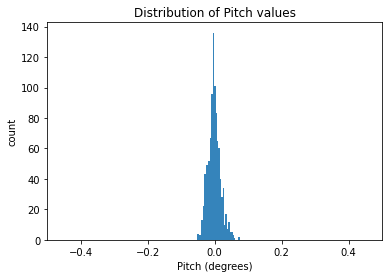

In [352]:
path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'


stim = experiment_stimuli(raw_data)
print(len(stim))

list_of_pitches = pitch_distribution(stim, path)

### Data Analysis

In [188]:
#Outlier Cleaning - Participant level 
import collections

def get_participant_ids(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

def get_participant_average_std(df, subjID):
    """
    Calculate participant's average depth estimate (across duration)
    Calculate participant's std (across duration)
    
    """
    all_data = pd.concat(df, ignore_index=True)

    subj_df = all_data.loc[all_data['subjID'] == subjID]
    
    avg = subj_df["depth_estimate"].mean()
    std = subj_df["depth_estimate"].std()
#     print(subjID, avg)
    
    return avg, std

def participant_OutlierRemoval(df):
    '''
    Each participant's average depth estimation is calculated (across duration).
    Calculate outlier range: (-3SD, +3SD) --> if an estimate is outside that participant's range, then remove as outlier
    Removes participants that have 10% or more missing trials 
    
    Args:
        df = [df_250, df_500, df_750, df_1000]
        
    Returns:
        [Data before outliers were removed, Data with outliers removed according to guidelines stated above.] 
        Data is in this format: [df_250, df_500, df_750, df_1000]
    '''
    
    participant_ids = get_participant_ids(df) #calls function to get a list of participant IDs 

    new_df = [] #updated dataframes are added to this list 
    for duration_df in df:
        duration_participant_dfs = []
        for p_id in participant_ids: #calculate average, standard deviation, and outlier parameters for each participant 
            select_participant = duration_df.where(duration_df["subjID"] == p_id) #selects rows by participant ID 
            p_avg, p_std = get_participant_average_std(df, p_id)
            
            new_participant = select_participant
            new_participant["Participant's Average"] = p_avg
            new_participant["Participant's StDev"] = p_std
            
            avg_minus_3SD = p_avg - (3 * p_std)
            avg_plus_3SD = p_avg + (3 * p_std)
            new_participant["Avg-3SD"] = avg_minus_3SD
            new_participant["Avg+3SD"] = avg_plus_3SD
            
            new_participant = new_participant.dropna() #remove all rows with NaN 
            duration_participant_dfs.append(new_participant)
        
        new_duration_df = pd.concat(duration_participant_dfs) #combine data for all participants of a specific duration 
        new_df.append(new_duration_df) #add duration dataframe to list of all data frames 
    
    outlier_distribution = {}
    participant_distribution = {}
    for dur in new_df:
        p_outlier_col = [] #list of outlier values in the duration data frame 
        for idx, row in dur.iterrows():
            subj = row['subjID']
            p_actual = row['actual_depth']
            p_estim = row["depth_estimate"]
            p_avg_minus_3SD = row["Avg-3SD"]
            p_avg_plus_3SD = row["Avg+3SD"]
            if p_estim < p_avg_minus_3SD or p_estim > p_avg_plus_3SD: #label as outlier 
                p_outlier_col.append(1)
                if p_actual not in outlier_distribution:
                    outlier_distribution[p_actual] = 1
                else:
                    outlier_distribution[p_actual] += 1
                    
                if subj not in participant_distribution:
                    participant_distribution[subj] = 1
                else:
                    participant_distribution[subj] += 1
            else: #not an outlier 
                p_outlier_col.append(0)
        dur["Outlier"] = p_outlier_col #add values to the data frame 
        
    pre_outlier = new_df.copy()
    post_outlier = new_df.copy()
    
    count_outlier1 = [] #list of outlier removed for each duration 
    for dur in post_outlier: #if the value is an outlier, then remove it 
        indexNames = dur[dur["Outlier"] == 1].index
        dur.drop(indexNames, inplace=True)
        count_outlier1.append(len(indexNames)) #count of number of outliers removed for each duration 
    
#     print("Number of outliers by duration")
#     print(count_outlier1)
#     print("Number of outliers by actual depth")
#     od = collections.OrderedDict(sorted(outlier_distribution.items()))
#     print(od)
#     print("Number of outliers by participant")
#     print(participant_distribution)
    
    # remove participants data if the participant's outlier count is 10% or more of num_trials
    threshold = math.floor(256 * 0.1)
#     print("Outlier Count Threshold: ", threshold)
    remove_ids = []
    for key in participant_distribution:
        if participant_distribution[key] >= threshold:
            remove_ids.append(key)
    print("Participants that are removed (outlier): ", remove_ids)
    
    for df in post_outlier:
        for index, row in df.iterrows():
            if row['subjID'] in remove_ids:
                df.drop(index, inplace=True)

    dropped_df = [] #new list of dataframes with columns from outlier removal removed 
    for duration_df in post_outlier:
        duration_df = duration_df.drop(["Participant's Average", "Participant's StDev", "Avg-3SD", "Avg+3SD", "Outlier" ], axis = 1)
        dropped_df.append(duration_df)

    return pre_outlier, dropped_df


In [207]:
preoutlier, raw_postOutlier_data = participant_OutlierRemoval(raw_data)


Participants that are removed (outlier):  []


### Remove participants with average depth estimations > 3SD from mean

In [60]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)


In [208]:
subjects = get_subjIDs(raw_postOutlier_data)

print("Post missing trial removal, and outlier removal")
print('N = ' + str(len(subjects)))



Post missing trial removal, and outlier removal
N = 180


In [242]:
def averageEstimHistogram(post_outlier_data, subjectlist):
    subjAverages = []
    subj_removed = []
    
    df = pd.concat(post_outlier_data)
    
    for subj in subjectlist:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()
        subjAverages.append(avg)            
            
    num_bins = len(subjAverages)
    n, bins, patches = plt.hist(subjAverages, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Average Distance Estimate')
    plt.show()
    
    mids = 0.5*(bins[1:] + bins[:-1])
    probs = n / np.sum(n)

    mean = np.sum(probs * mids)  
    sd = np.sqrt(np.sum(probs * (mids - mean)**2))
    
    print('Mean: ', mean)
    print('Standard Deviation: ', sd)
    threshold = mean + (3 * sd)
    print("Mean + 3SD: ", threshold )
    
    stds = []
    count = 0
    for subj in subjectlist:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()
        std = subj_df['depth_estimate'].std()
        if std < 0.5:
            print(subj)
            count += 1
        stds.append(std)
        
        if avg > threshold:
            subj_removed.append(subj)
            
    print("Standard Deviation below 0.5: ", count)

#     plt.xlim([0, 10])
#     plt.hist(stds, bins=192, alpha=0.9)
#     plt.title('Distribution of Participant Depth Estimate Standard Deviations')
#     plt.xlabel('Std')
#     plt.ylabel('count')

    print("Participants that are removed: ", subj_removed)
    
    cleaned_subjAverages = [avg for avg in subjAverages if avg <= threshold ]
    print("N = ", len(cleaned_subjAverages))
    cleaned_mean = np.mean(np.array(cleaned_subjAverages))
    print("Average Depth Estimate Post-Cleaning: ", cleaned_mean)
    
    for index, row in df.iterrows():
        if row['subjID'] in subj_removed:
            df.drop(index, inplace=True)
    
    data_250ms = df[df['duration'] == 250.0]
    data_500ms = df[df['duration'] == 500.0]
    data_750ms = df[df['duration'] == 750.0]
    data_1000ms = df[df['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]
    

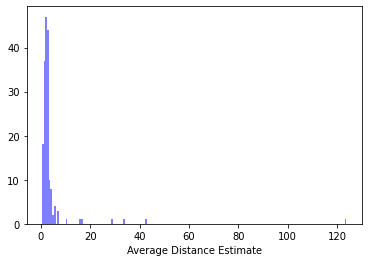

Mean:  3.8358502267257295
Standard Deviation:  10.071124624889299
Mean + 3SD:  34.04922410139363
595494.0
399453.0
950876.0
992366.0
304244.0
505463.0
223948.0
131855.0
615211.0
984878.0
334221.0
796561.0
255389.0
353720.0
926651.0
840133.0
651223.0
426983.0
813556.0
515067.0
Standard Deviation below 0.5:  20
Participants that are removed:  [329403.0, 727033.0]
N =  178
Average Depth Estimate Post-Cleaning:  2.93217646044114


In [243]:
cleaned_data = averageEstimHistogram(raw_postOutlier_data, subjects)

In [64]:
def avgEstim(data, subjects, condition):
    """
    Calculate average depth estimation either for a duration condition, or all the data
    Args:
    data = cleaned_data
    subjects = list of subjects after
               (1) subjects with more than 10% missing trials are removed
               (2) subjects with more than 10% outlier trials are removed
               (3) subjects with avg estim >= mean + 3SD are removed 
    condition = duration index or None, indicating calculate average across all durations
    Returns:
        Average depth estimation in meters 
    """
    if condition == None:
        df = pd.concat(data)
        avg_estim = np.mean(np.array(df['depth_estimate']))
    else:
        df = data[condition]
        avg_estim = np.mean(np.array(df['depth_estimate']))
        
    
    return avg_estim

In [65]:
subjects = get_subjIDs(cleaned_data)

all_conditions_avgestim = avgEstim(cleaned_data, subjects, None)

avgestim_250 = avgEstim(cleaned_data, subjects, 0)

avgestim_500 = avgEstim(cleaned_data, subjects, 1)

avgestim_750 = avgEstim(cleaned_data, subjects, 2)

avgestim_1000 = avgEstim(cleaned_data, subjects, 3)

avg_estimates = [all_conditions_avgestim, avgestim_250, avgestim_500, avgestim_750, avgestim_1000]

In [66]:
avg_estimates

[2.933314865090736,
 2.882213707766991,
 2.939747372427739,
 2.973036993933627,
 2.9372262863905334]

In [68]:
def avgActual(data, subjects, condition):
    """
    Calculate average actual depth either for a duration condition, or all the data
    Args:
    data = cleaned_data
    subjects = list of subjects after
               (1) subjects with more than 10% missing trials are removed
               (2) subjects with more than 10% outlier trials are removed
               (3) subjects with avg estim >= mean + 3SD are removed 
    condition = duration index or None, indicating calculate average across all durations
    Returns:
        Average depth estimation in meters 
    """
    if condition == None:
        df = pd.concat(data)
        avg_actual = np.mean(np.array(df['actual_depth']))
    else:
        df = data[condition]
        avg_actual = np.mean(np.array(df['actual_depth']))
        
    
    return avg_actual

In [69]:
subjects = get_subjIDs(cleaned_data)

all_conditions_avg = avgActual(cleaned_data, subjects, None)

avg_250 = avgActual(cleaned_data, subjects, 0)

avg_500 = avgActual(cleaned_data, subjects, 1)

avg_750 = avgActual(cleaned_data, subjects, 2)

avg_1000 = avgActual(cleaned_data, subjects, 3)

avg_actual = [all_conditions_avg, avg_250, avg_500, avg_750, avg_1000]

In [70]:
avg_actual

[3.0223615090735434,
 3.02748786407767,
 3.0212323064113242,
 3.01935292018556,
 3.021479289940829]

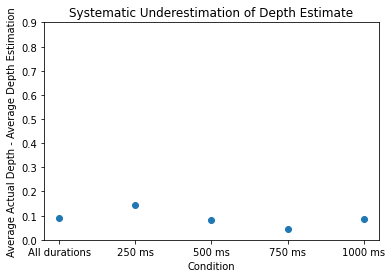

In [71]:
import matplotlib.pyplot as plt
import numpy as np

x = ['All durations', '250 ms', '500 ms', '750 ms', '1000 ms']
y = np.subtract(np.array(avg_actual), np.array(avg_estimates))


plt.scatter(x, y)
plt.yticks(np.arange(0,1, 0.1))
plt.xlabel('Condition')  
plt.ylabel('Average Actual Depth - Average Depth Estimation') 
plt.title('Systematic Underestimation of Depth Estimate')
plt.show()

### Create normalized dfs

In [72]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

In [73]:
subjects = get_subjIDs(cleaned_data)

print("Post missing trial removal, outlier removal, and average depth estimation cleaning")
print('N = ' + str(len(subjects)))



Post missing trial removal, outlier removal, and average depth estimation cleaning
N = 178


In [74]:
def normalize_dfs(data, subjectlist):
    """
    Args:
        data = list of duration dfs after outlier removal 
        subjectlist = list of subjects after outlier removal and filtering by average depth estimation 
    Return:
        norm_data = list of duration dfs after data normalization by particpants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'
    df = pd.concat(data) 
    
    norm_subjects = []
    for subj in subjectlist:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)
        
        # TESTING: Alternate normalization method
#         # subtract the participant’s mean from each depth estimate 
#         subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x-avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    # split into duration 
    data_250ms = normalized_df[normalized_df['duration'] == 250.0]
    data_500ms = normalized_df[normalized_df['duration'] == 500.0]
    data_750ms = normalized_df[normalized_df['duration'] == 750.0]
    data_1000ms = normalized_df[normalized_df['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]


In [75]:
normalized_cleaned_data = normalize_dfs(cleaned_data, subjects)

In [77]:
def pivotTable_post_participant_level_outlier(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
        
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
    
    return result_tables

In [78]:
raw_pivot = pivotTable_post_participant_level_outlier(cleaned_data)
normalized_pivot = pivotTable_post_participant_level_outlier(normalized_cleaned_data)

Double Check Participant Count

In [222]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

In [79]:
subjects = get_subjIDs(normalized_cleaned_data)

print("Post missing trial removal, outlier removal, and average depth estimation cleaning")
print('N = ' + str(len(subjects)))



Post missing trial removal, outlier removal, and average depth estimation cleaning
N = 178


In [80]:
import scipy.stats as stats

def _getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        xs = [x_250, x_500, x_750, x_1000]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    for table in data:
        x = []
        y = []
        ste = []
        for idx, row in table.iterrows():
            x.append(idx) #idx is the actual depth value 
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        
    return xs, ys, stes 



In [81]:
raw_final = _getxy(raw_pivot)
normalized_final = _getxy(normalized_pivot) 

In [82]:
def _createVars(final_data):
    """
    Create variables for final data by duration, for a specific sequence 
    """
    final_x_250 = final_data[0][0]
    final_y_250 = final_data[1][0]
    ste_250 = final_data[2][0]

    final_x_500 = final_data[0][1]
    final_y_500 = final_data[1][1]
    ste_500 = final_data[2][1]

    final_x_750 = final_data[0][2]
    final_y_750 = final_data[1][2]
    ste_750 = final_data[2][2]

    final_x_1000 = final_data[0][3]
    final_y_1000 = final_data[1][3]
    ste_1000 = final_data[2][3]
    
    return [[final_x_250, final_y_250, ste_250], 
            [final_x_500, final_y_500, ste_500], 
            [final_x_750, final_y_750, ste_750], 
            [final_x_1000, final_y_1000, ste_1000]]



In [83]:
raw_final_vars = _createVars(raw_final)
normalized_final_vars = _createVars(normalized_final)

In [94]:
#Calculate the T-test for the means of two independent samples of scores.

#This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
#This test assumes that the populations have identical variances by default.
def _durationStatsTests(finaldata):
    
    final_y_250 = finaldata[0][1]
    final_y_500 = finaldata[1][1]
    final_y_750 = finaldata[2][1]
    final_y_1000 = finaldata[3][1]
    
    print("250ms vs. 500ms")
    ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
    print(ttest_250_500)
    print("250ms vs. 750ms")
    ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
    print(ttest_250_750)
    print("250ms vs. 1000ms")
    ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
    print(ttest_250_1000)
    print("500ms vs. 750ms")
    ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
    print(ttest_500_750)
    print("500ms vs. 1000ms")
    ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
    print(ttest_500_1000)
    print("750ms vs. 1000ms")
    ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
    print(ttest_750_1000)
    
    # stats f_oneway functions takes the groups as input and returns F and P-value
    fvalue, pvalue = stats.f_oneway(final_y_250, final_y_500, final_y_750, final_y_1000)
    print("All durations: fvalue=", fvalue, "pvalue=",pvalue)
    
    return None 

print("Results")
raw_ttests = _durationStatsTests(raw_final_vars)

print('\n')
print("Normalized Results")
normalized_ttests = _durationStatsTests(normalized_final_vars)

Results
250ms vs. 500ms
Ttest_indResult(statistic=-0.5084167629345574, pvalue=0.612633765482374)
250ms vs. 750ms
Ttest_indResult(statistic=-0.7039483720482195, pvalue=0.483616241492111)
250ms vs. 1000ms
Ttest_indResult(statistic=-0.5046470879496321, pvalue=0.6152668375064586)
500ms vs. 750ms
Ttest_indResult(statistic=-0.17152595265488788, pvalue=0.8642661147814076)
500ms vs. 1000ms
Ttest_indResult(statistic=0.043257412186711613, pvalue=0.9656097897278069)
750ms vs. 1000ms
Ttest_indResult(statistic=0.22749791238431966, pvalue=0.8206474870007101)
All durations: fvalue= 0.17090826107509877 pvalue= 0.9159066776129225


Normalized Results
250ms vs. 500ms
Ttest_indResult(statistic=-0.7088512490620741, pvalue=0.48058557075555297)
250ms vs. 750ms
Ttest_indResult(statistic=-0.8375647848695537, pvalue=0.40490141291503523)
250ms vs. 1000ms
Ttest_indResult(statistic=-0.7951831799458033, pvalue=0.4289833965349793)
500ms vs. 750ms
Ttest_indResult(statistic=-0.1235620237490321, pvalue=0.9019882616865

## One-Way Repeated Measures ANOVA

https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php

IV conditions: Duration - 250, 500, 750, 1000

IV: Actual Depth

DV: Depth Estimate 

H0: µ1 = µ2 = µ3 = … = µk where µ = population mean and k = number of related groups. 

HA: at least two means are significantly different

In [95]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM


def _subjectData(folderpath, normalize, threshold):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    data = []
    for filename in os.listdir(folderpath):
        if 'csv' in filename:
            path = folderpath + "/" + filename
            ############ get data ############
            cleaned_data  = removeIncorrectlyTaggedImageTrials(path)
            # skips participants whose data was removed due to too many outliers or missed trials
            # checks number of rows in df_250 
            if cleaned_data[0].shape[0] > 1:            
                postOutlier_data = participant_OutlierRemoval(cleaned_data)[1]
                
                if normalize == False:
                    subj_df = pd.concat(postOutlier_data)
                    # calculate subject's average depth estimation 
                    subj_avg = subj_df['depth_estimate'].mean()
                    # do not analyze participants with avg depth estimates greater than mean + 3SD
                    if subj_avg <= threshold:
                        pivot = pivotTable_post_participant_level_outlier(postOutlier_data)
                        subj_data = _getxy(pivot)
                        data.append(subj_data)
                        
                if normalize == True:
                    subj_df = pd.concat(postOutlier_data)
                    # calculate subject's average depth estimation 
                    subj_avg = subj_df['depth_estimate'].mean()
                    # do not analyze participants with avg depth estimates greater than mean + 3SD
                    if subj_avg <= threshold:
                        subjects = get_subjIDs(postOutlier_data)
                        normalized_postOutlier_data = normalize_dfs(postOutlier_data, subjects)

                        normalized_pivot = pivotTable_post_participant_level_outlier(normalized_postOutlier_data)
                        normalized_subj_data = _getxy(normalized_pivot) 
                        data.append(normalized_subj_data)

    return data # list of data for all subjects 

def _buildDF_subjectLinReg(folderpath, normalize, threshold):
    """
    Plot slopes for each participant
    """
    
    dict_data_slope = {'participant': [], 'duration': [], 'slope': []}
    
    dict_data_intercept = {'participant': [], 'duration': [], 'intercept': []}
    
    data = _subjectData(folderpath, normalize, threshold)
    durations = [250, 500, 750, 1000]
    participant = 0
    for subject in data:
        for i in range(len(durations)): 
            final_x = subject[0][i]
            final_y = subject[1][i]
            ste = subject[2][i]

            x = np.array(final_x)
            y = np.array(final_y)
            ste = np.array(ste)

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            dict_data_slope['participant'].append(participant)
            dict_data_slope['duration'].append(durations[i])
            dict_data_slope['slope'].append(slope)
            
            dict_data_intercept['participant'].append(participant)
            dict_data_intercept['duration'].append(durations[i])
            dict_data_intercept['intercept'].append(intercept)
        
        participant += 1
            
    df_slope = pd.DataFrame(data=dict_data_slope)
    
    df_intercept = pd.DataFrame(data=dict_data_intercept)
    
    return df_slope, df_intercept

# def _getDurationAvgs(folderpath):
#     df_slope, df_intercept = _buildDF_subjectLinReg(folderpath)
    
#     df_slope_250 = df_slope[df_slope["duration"] == 250]
#     df_slope_500 = df_slope[df_slope["duration"] == 500]
#     df_slope_750 = df_slope[df_slope["duration"] == 750]
#     df_slope_1000 = df_slope[df_slope["duration"] == 1000]
    
#     slope_avgs = {'250': df_slope_250['slope'].mean(),
#                   '500': df_slope_500['slope'].mean(), 
#                   '750': df_slope_750['slope'].mean(),
#                   '1000': df_slope_1000['slope'].mean()}
    
#     df_intercept_250 = df_intercept[df_intercept["duration"] == 250]
#     df_intercept_500 = df_intercept[df_intercept["duration"] == 500]
#     df_intercept_750 = df_intercept[df_intercept["duration"] == 750]
#     df_intercept_1000 = df_intercept[df_intercept["duration"] == 1000]
    
#     intercept_avgs = {'250': df_intercept_250['intercept'].mean(),
#                   '500': df_intercept_500['intercept'].mean(), 
#                   '750': df_intercept_750['intercept'].mean(),
#                   '1000': df_intercept_1000['intercept'].mean()}
    
#     print("Subject Slope Average for each Duration")
#     print(slope_avgs)
    
#     print("Subject Intercept Average for each Duration")
#     print(intercept_avgs)
        

def _repeatedMeasuresANOVA(folderpath, normalize, threshold):

    df_slope = _buildDF_subjectLinReg(folderpath, normalize, threshold)[0]
    print("Dependent variable: Participant Slopes")
    #perform the repeated measures ANOVA
    print(AnovaRM(data=df_slope, depvar='slope', subject='participant', within=['duration']).fit())
    
    df_intercept = _buildDF_subjectLinReg(folderpath, normalize, threshold)[1]
    print("Dependent variable: Participant Intercepts")
    #perform the repeated measures ANOVA
    print(AnovaRM(data=df_intercept, depvar='intercept', subject='participant', within=['duration']).fit())



path = '/Users/prachi/Documents/depth_duration/analysis/data'

avg_plus_3SD = 34.04922410139363

# Second argument sets if data gets normalized by participants avg depth estimation 
print("Raw Data")
results = _repeatedMeasuresANOVA(path, False, avg_plus_3SD)


print("Normalized Data")
normalized = _repeatedMeasuresANOVA(path, True, avg_plus_3SD)



Raw Data
Dependent variable: Participant Slopes
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  1.9541 3.0000 354.0000 0.1206

Dependent variable: Participant Intercepts
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  1.1787 3.0000 354.0000 0.3177

Normalized Data
Dependent variable: Participant Slopes
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 14.9987 3.0000 354.0000 0.0000

Dependent variable: Participant Intercepts
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  7.0938 3.0000 354.0000 0.0001



### Need to check assumptions

## Plot Duration Slopes

### Raw Data

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def linreg_duration(x, y, ste, duration):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 1, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 1.4, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "blue")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "blue")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [97]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = raw_final
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.46811867]
b: 1.4321527687556577
R-squared:  0.6739763270557537


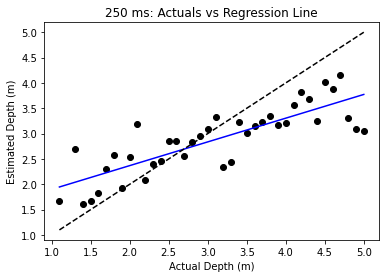

In [98]:
from sklearn.linear_model import LinearRegression
#run regression
X_250 = np.array(final_x_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black');
plt.plot(X_250,y_predicted_250,color='blue')
plt.title("250 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

Text(0, 0.5, 'Residual')

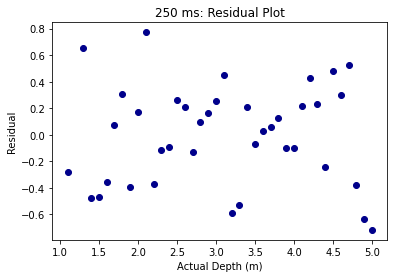

In [99]:
residuals_250 = y_250-y_predicted_250
plt.plot(X_250,residuals_250, 'o', color='darkblue')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [299]:
# http://www.hackdeploy.com/python-linear-regression-analysis/
# import statsmodels.api as sm
# est = sm.OLS(y, X)
# est2 = est.fit()
# print(est2.summary())

slope: 0.468119    intercept: 1.432153
R-squared: 0.673976
Standard-error: 0.053525


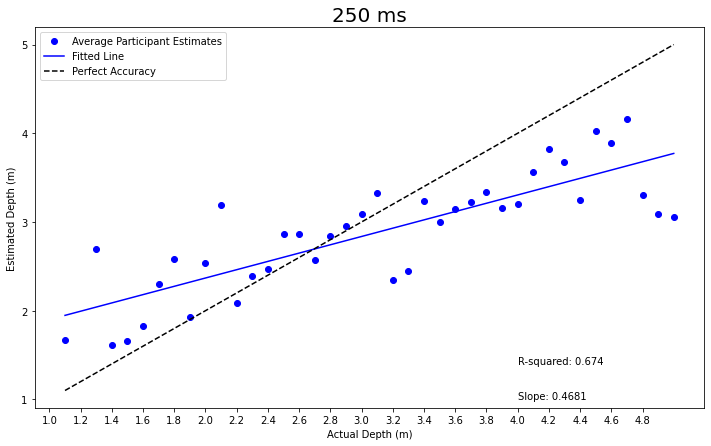

In [100]:
slope_250 = linreg_duration(final_x_250, final_y_250, ste_250, 250)[0]

m: [0.66657506]
b: 0.9028280979171681
R-squared:  0.863918089289123


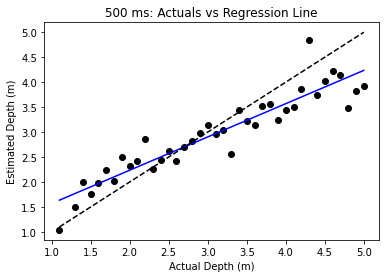

In [101]:
from sklearn.linear_model import LinearRegression
#run regression
X_500 = np.array(final_x_500).reshape(-1,1)
y_500 = final_y_500
reg_500 = LinearRegression().fit(X_500, y_500)

#Generated Predictions
y_predicted_500 = reg_500.predict(X_500)
#Plot Our Actual and Predicted Values
plt.plot(X_500, y_500, 'o', color='black');
plt.plot(X_500,y_predicted_500,color='blue')
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_500, X_500, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_500.coef_))
print("b: {0}".format(reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_500.score(X_500, y_500))

Text(0, 0.5, 'Residual')

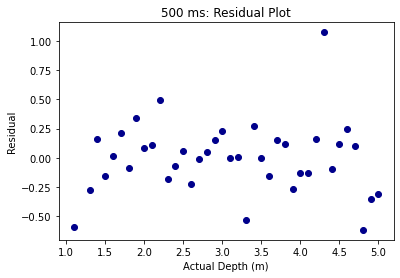

In [102]:
residuals_500 = y_500-y_predicted_500
plt.plot(X_500,residuals_500, 'o', color='darkblue')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.666575    intercept: 0.902828
R-squared: 0.863918
Standard-error: 0.043492


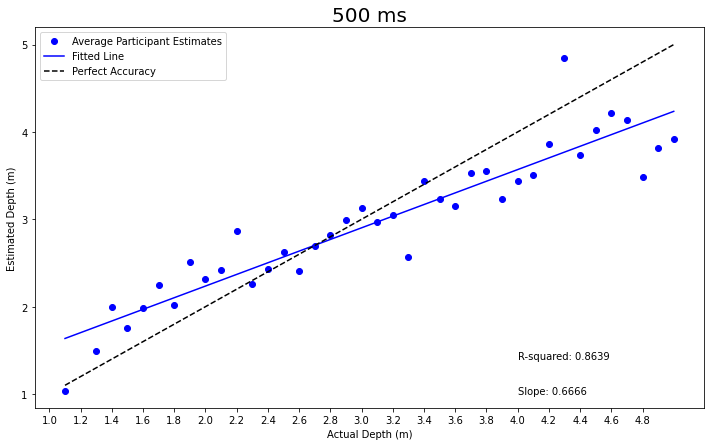

In [103]:
slope_500 = linreg_duration(final_x_500, final_y_500, ste_500, 500)[0]

m: [0.59122354]
b: 1.1678429277079139
R-squared:  0.7031740894680858


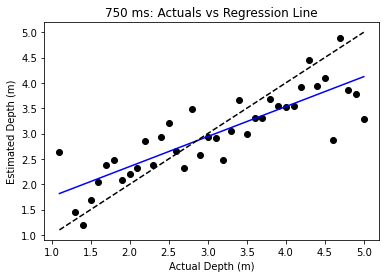

In [104]:
from sklearn.linear_model import LinearRegression
#run regression
X_750 = np.array(final_x_750).reshape(-1,1)
y_750 = final_y_750
reg_750 = LinearRegression().fit(X_750, y_750)

#Generated Predictions
y_predicted_750 = reg_750.predict(X_750)
#Plot Our Actual and Predicted Values
plt.plot(X_750, y_750, 'o', color='black');
plt.plot(X_750,y_predicted_750,color='blue')
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_750, X_750, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_750.coef_))
print("b: {0}".format(reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_750.score(X_750, y_750))

Text(0, 0.5, 'Residual')

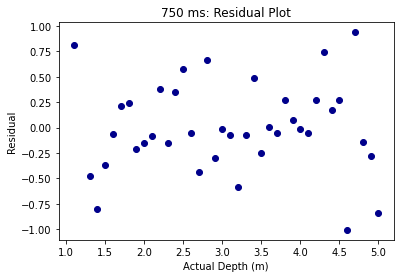

In [105]:
residuals_750 = y_750-y_predicted_750
plt.plot(X_750,residuals_750, 'o', color='darkblue')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.591224    intercept: 1.167843
R-squared: 0.703174
Standard-error: 0.063150


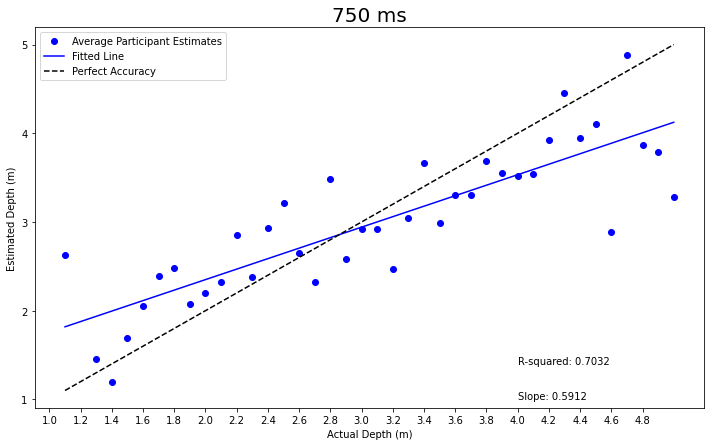

In [106]:
slope_750 = linreg_duration(final_x_750, final_y_750, ste_750, 750)[0]

m: [0.57960951]
b: 1.1646853585103143
R-squared:  0.8758901887735772


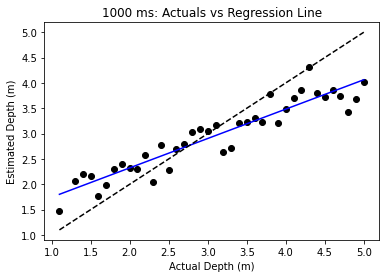

In [108]:
from sklearn.linear_model import LinearRegression
#run regression
X_1000 = np.array(final_x_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black');
plt.plot(X_1000,y_predicted_1000,color='blue')
plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

Text(0, 0.5, 'Residual')

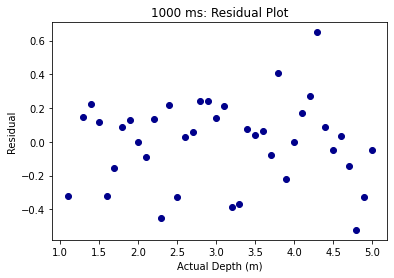

In [109]:
residuals_1000 = y_1000-y_predicted_1000
plt.plot(X_1000,residuals_1000, 'o', color='darkblue')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.579610    intercept: 1.164685
R-squared: 0.875890
Standard-error: 0.035868


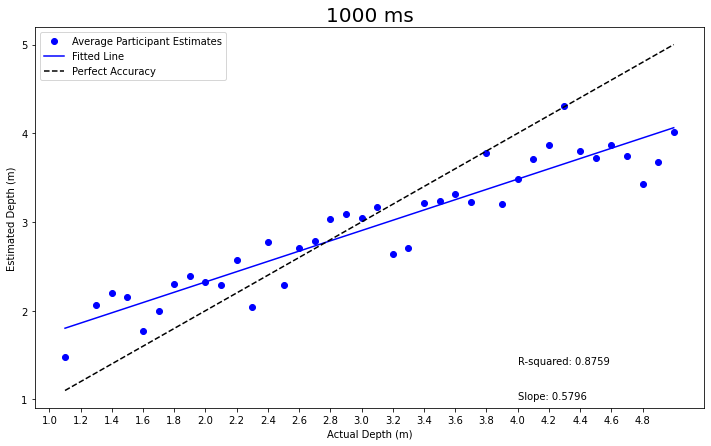

In [110]:
slope_1000 = linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000)[0]

#### Summary Plots for Non-Normalized Data

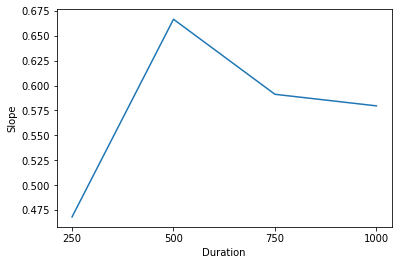

In [111]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.plot(xAxis,slopes)
plt.xlabel('Duration')
plt.ylabel('Slope')
plt.show()

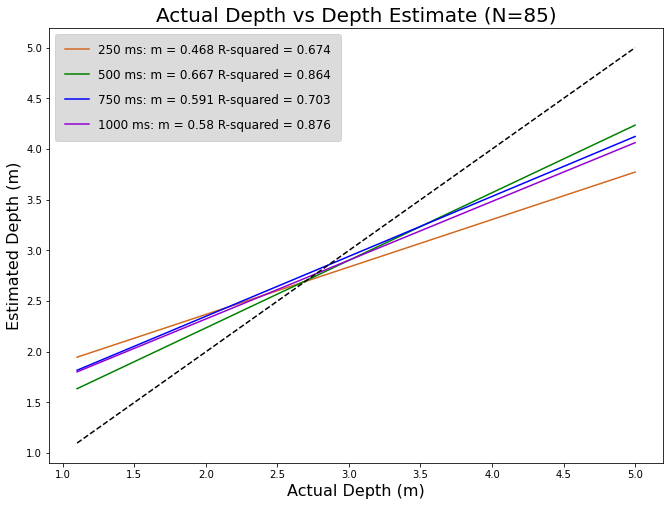

In [112]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [11, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_250.score(X_250, y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(X_500,y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_500.score(X_500, y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(X_750,y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_750.score(X_750, y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(reg_1000.score(X_1000, y_1000), 3)))

plt.title("Actual Depth vs Depth Estimate (N=85)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

### Normalized Data

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normalized_linreg_duration(x, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.5, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.7, text_r2) 
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "purple")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "purple")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x/avg, label = "Perfect Accuracy Normalized", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [114]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = normalized_final
avg_average_particip_estim = 3.8358502267257295 # calculated in depthDuration_analysis.ipynb
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.20112957]
b: 0.3522832806864976
R-squared:  0.8866013040993489


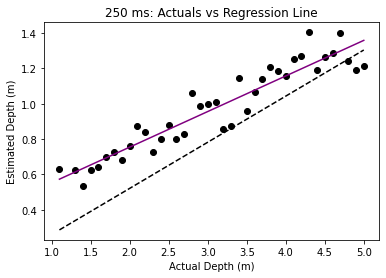

In [115]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_250 = np.array(final_x_250).reshape(-1,1)
n_y_250 = final_y_250
n_reg_250 = LinearRegression().fit(n_X_250, n_y_250)

#Generated Predictions
n_y_predicted_250 = n_reg_250.predict(n_X_250)
#Plot Our Actual and Predicted Values
plt.plot(n_X_250, n_y_250, 'o', color='black');
plt.plot(n_X_250,n_y_predicted_250,color='purple')
plt.title("250 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_250, n_X_250/avg_average_particip_estim, 
         label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(n_reg_250.coef_))
print("b: {0}".format(n_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_250.score(n_X_250, n_y_250))

Text(0, 0.5, 'Residual')

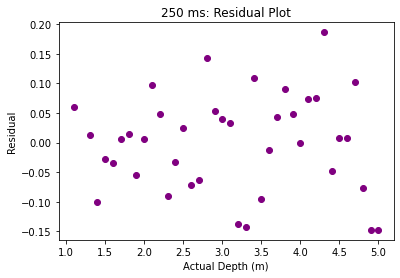

In [116]:
n_residuals_250 = n_y_250-n_y_predicted_250
plt.plot(n_X_250,n_residuals_250, 'o', color='purple')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.201130    intercept: 0.352283
R-squared: 0.886601
Standard-error: 0.011825


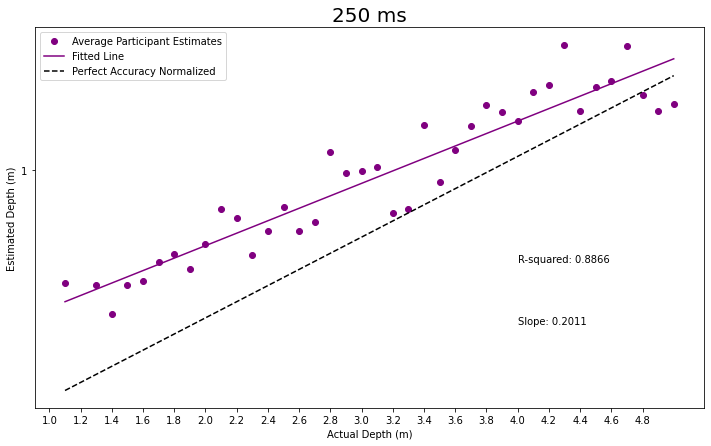

In [117]:
slope_250 = normalized_linreg_duration(final_x_250, final_y_250, ste_250, 250,
                                       avg_average_particip_estim)[0]

m: [0.25130092]
b: 0.24081179616741355
R-squared:  0.9192751423450225


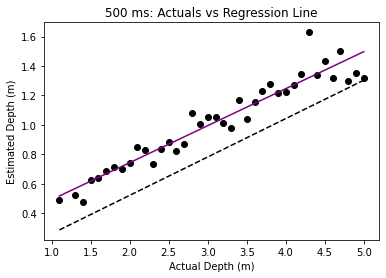

In [118]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_500 = np.array(final_x_500).reshape(-1,1)
n_y_500 = final_y_500
n_reg_500 = LinearRegression().fit(n_X_500, n_y_500)

#Generated Predictions
n_y_predicted_500 = n_reg_500.predict(n_X_500)
#Plot Our Actual and Predicted Values
plt.plot(n_X_500, n_y_500, 'o', color='black');
plt.plot(n_X_500,n_y_predicted_500,color='purple')
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_500, n_X_500/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(n_reg_500.coef_))
print("b: {0}".format(n_reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_500.score(n_X_500, n_y_500))

Text(0, 0.5, 'Residual')

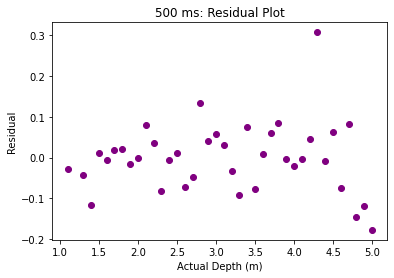

In [119]:
n_residuals_500 = n_y_500-n_y_predicted_500
plt.plot(n_X_500,n_residuals_500, 'o', color='purple')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.251301    intercept: 0.240812
R-squared: 0.919275
Standard-error: 0.012243


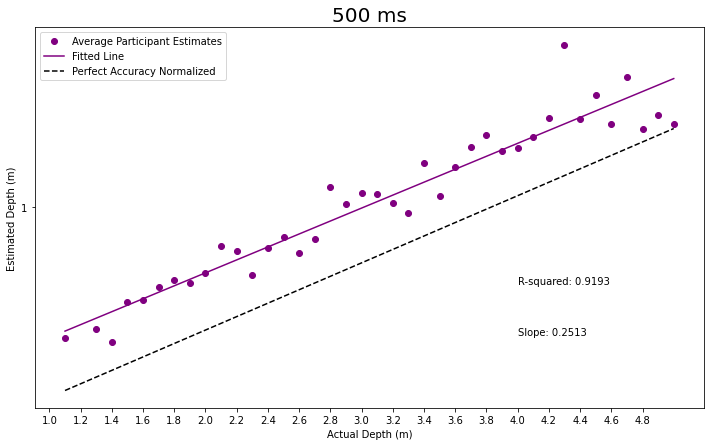

In [120]:
slope_500 = normalized_linreg_duration(final_x_500, final_y_500, ste_500, 500,
                                       avg_average_particip_estim)[0]

m: [0.25397258]
b: 0.24099645834190697
R-squared:  0.9105955459696543


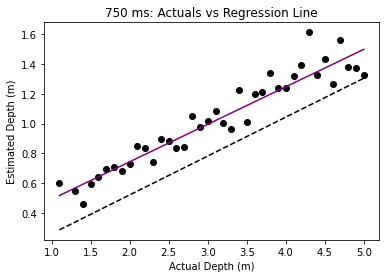

In [121]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_750 = np.array(final_x_750).reshape(-1,1)
n_y_750 = final_y_750
n_reg_750 = LinearRegression().fit(n_X_750, n_y_750)

#Generated Predictions
n_y_predicted_750 = n_reg_750.predict(n_X_750)
#Plot Our Actual and Predicted Values
plt.plot(n_X_750, n_y_750, 'o', color='black');
plt.plot(n_X_750,n_y_predicted_500,color='purple')
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_750, n_X_750/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(n_reg_750.coef_))
print("b: {0}".format(n_reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_750.score(n_X_750, n_y_750))

Text(0, 0.5, 'Residual')

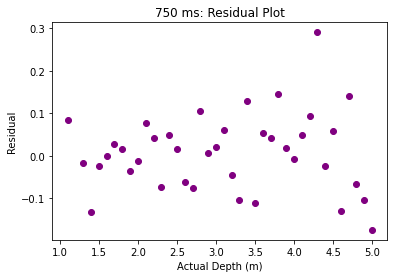

In [122]:
n_residuals_750 = n_y_750-n_y_predicted_500
plt.plot(n_X_750,n_residuals_750, 'o', color='purple')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.253973    intercept: 0.240996
R-squared: 0.910596
Standard-error: 0.013083


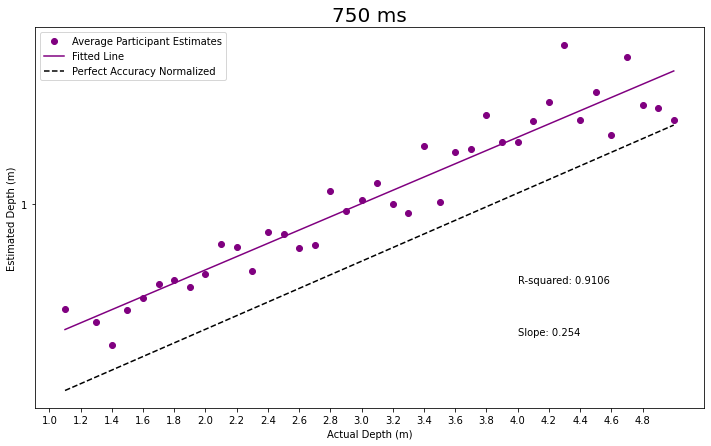

In [123]:
slope_750 = normalized_linreg_duration(final_x_750, final_y_750, ste_750, 750,
                                       avg_average_particip_estim)[0]

m: [0.25063564]
b: 0.24877716505301484
R-squared:  0.8812379718693331


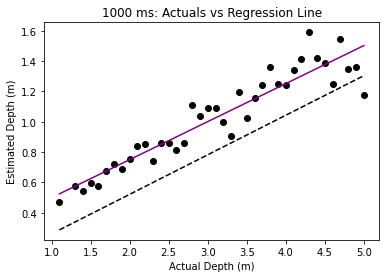

In [124]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_1000 = np.array(final_x_1000).reshape(-1,1)
n_y_1000 = final_y_1000
n_reg_1000 = LinearRegression().fit(n_X_1000, n_y_1000)

#Generated Predictions
n_y_predicted_1000 = n_reg_1000.predict(n_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(n_X_1000, n_y_1000, 'o', color='black');
plt.plot(n_X_1000,n_y_predicted_1000,color='purple')
plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_1000, n_X_1000/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(n_reg_1000.coef_))
print("b: {0}".format(n_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_1000.score(n_X_1000, n_y_1000))

Text(0, 0.5, 'Residual')

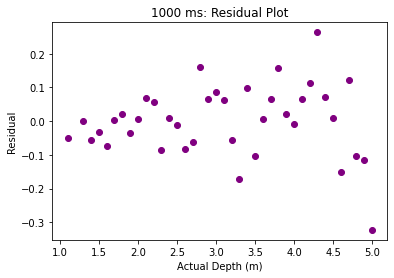

In [125]:
n_residuals_1000 = n_y_1000-n_y_predicted_1000
plt.plot(n_X_1000,n_residuals_1000, 'o', color='purple')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.250636    intercept: 0.248777
R-squared: 0.881238
Standard-error: 0.015126


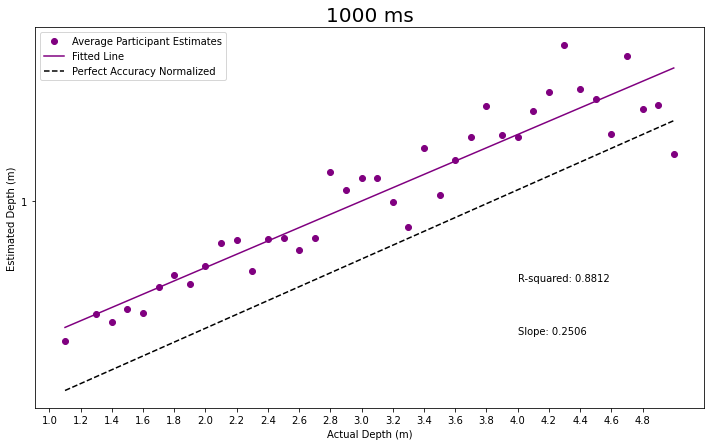

In [126]:
slope_1000 = normalized_linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000,
                                       avg_average_particip_estim)[0]

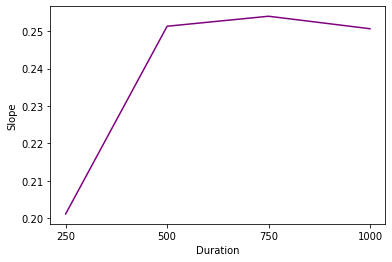

In [127]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.plot(xAxis,slopes, color='purple')
plt.xlabel('Duration')
plt.ylabel('Slope')
plt.show()

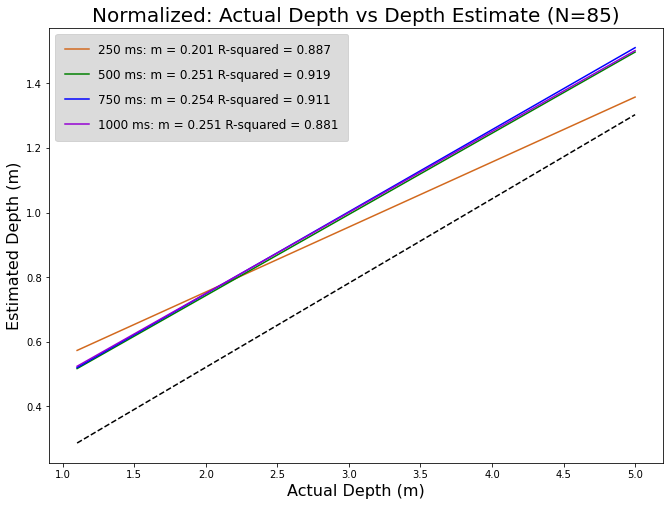

In [128]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [11, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(n_X_250,n_y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(n_reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_250.score(n_X_250, n_y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(n_X_500,n_y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(n_reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_500.score(n_X_500, n_y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(n_X_750,n_y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(n_reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_750.score(n_X_750, n_y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(n_X_1000,n_y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(n_reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(n_reg_1000.score(n_X_1000, n_y_1000), 3)))

plt.title("Normalized: Actual Depth vs Depth Estimate (N=85)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(n_X_1000, n_X_1000/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

### Individual Target Results


In [133]:
import pandas as pd 
import scipy.stats as stats


def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables



In [135]:
raw_trial_pivot = trial_pivotTable(cleaned_data)
normalized_trial_pivot = trial_pivotTable(normalized_cleaned_data)
# raw_trial_pivot[0]

In [ ]:
# _250 = np.array(stim_250).reshape(1,-1)
# std_250 = np.std(_250[0])

In [136]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)
            
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)

    return xs, ys, stes, actualdepths, stds



In [137]:
trial_raw_final = trial_getxy(raw_trial_pivot)
trial_normalized_final = trial_getxy(normalized_trial_pivot)

Double Check Participant Count

In [232]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

In [138]:
subjects = get_subjIDs(cleaned_data)

print("Post missing trial removal, outlier removal, and average depth estimation cleaning")
print('N = ' + str(len(subjects)))



Post missing trial removal, outlier removal, and average depth estimation cleaning
N = 178


#### Raw Data

In [139]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_250 = trial_plot_data[0][0]
final_y_250 = trial_plot_data[1][0]
ste_250 = trial_plot_data[2][0]
stim_250 = trial_plot_data[3][0]
std_250 = trial_plot_data[4][0]

final_x_500 = trial_plot_data[0][1]
final_y_500 = trial_plot_data[1][1]
ste_500 = trial_plot_data[2][1]
stim_500 = trial_plot_data[3][1]
std_500 = trial_plot_data[4][1]


final_x_750 = trial_plot_data[0][2]
final_y_750 = trial_plot_data[1][2]
ste_750 = trial_plot_data[2][2]
stim_750 = trial_plot_data[3][2]
std_750 = trial_plot_data[4][2]


final_x_1000 = trial_plot_data[0][3]
final_y_1000 = trial_plot_data[1][3]
ste_1000 = trial_plot_data[2][3]
stim_1000 = trial_plot_data[3][3]
std_1000 = trial_plot_data[4][3]


In [316]:
import numpy as np
import math

#Need to implement this code for ALL extrinsics files for all the images in SUNRGBD
#converts the rotation matrix in extrinsics.txt from string to a numpy array 
def rotationmatrix(matrix_path):
    matrixtext = open(matrix_path).read()
    
    x00 = float(matrixtext.split('\t')[0].split(' ')[0])
    x01 = float(matrixtext.split('\n')[0].split(' ')[1])
    x02 = float(matrixtext.split('\n')[0].split(' ')[2])
    
    x10 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[1].split(' ')[1])
    x12 = float(matrixtext.split('\n')[1].split(' ')[2])
    
    x20 = float(matrixtext.split('\n')[2].split(' ')[0])
    x21 = float(matrixtext.split('\n')[2].split(' ')[1])
    x22 = float(matrixtext.split('\n')[2].split(' ')[2])
    
    #list of the matrix values excluding the 3rd column of just zeroes 
    matrixlist = [[x00, x01, x02], [x10, x11, x12], [x20, x21, x22]]
    
    #creates 3x3 array of the rotation matrix
    matrixarray = np.full((3,3), matrixlist)
    
    return matrixarray

# Reference: https://www.learnopencv.com/rotation-matrix-to-euler-angles/

# Calculates rotation matrix to euler angles

# The result is the same as MATLAB except the order of the euler angles ( x and z are swapped ).

def rotationMatrixToEulerAngles(path):
    R = rotationmatrix(path)
    #assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

# Output - final roll, pitch, yaw values in radians and degrees 
def imageExtrinsics(path):
    in_array = rotationMatrixToEulerAngles(path)
    #print ("Radian values : \n", in_array) 

    degree_Values = np.degrees(in_array) 
    #print ("\nDegree values : \n", degree_Values) 
    
#     print ("\nRoll in Degrees : \n", degree_Values[0]) 
#     print ("\nPitch in Degrees : \n", degree_Values[1]) 
#     print ("\nYaw in Degrees : \n", degree_Values[2]) 
    
    return degree_Values
    
def get_img_number(stimulus_path):
    stim = stimulus_path.split('/')[-1]
    img_num = stim.split('_')[0]
    
    return img_num

def calculate_pitch(path, rootdir):
    """
    Args:
        path: stimulus path as noted in data csv files 
                 ex. 'depth_duration_stimuli/003396_3/003396_3-target.png
        rootdir: kinect2data folder path 
    Uses img_num to find the respective SUNRGBD folder --> uses extrinsics file to calculate yaw
    
    """
    img_num = get_img_number(path)
    for _dir in os.listdir(rootdir):
        split = _dir.split('_')[0]
        if split == img_num:
            path = rootdir + '/' + _dir
            for folder in os.listdir(path):
                if folder != '.DS_Store':
                    extpath = path + '/extrinsics'
                    os.listdir(extpath)
                    fname = os.listdir(extpath)[0]
                    if fname != '.ipynb_checkpoints':
                        extrinsics = imageExtrinsics(extpath + '/' + fname)
                        pitch = extrinsics[1]
                        return pitch 


In [317]:
                    
kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x --> calculate pitch 

pitch_250 = [calculate_pitch(path, kinectv2_path) for path in final_x_250]
pitch_500 = [calculate_pitch(path, kinectv2_path) for path in final_x_500]
pitch_750 = [calculate_pitch(path, kinectv2_path) for path in final_x_750]
pitch_1000 = [calculate_pitch(path, kinectv2_path) for path in final_x_1000]

##### Tilt 

In [40]:
def yaw(matrixtext):
    x21 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[0].split(' ')[0])
    return math.degrees(np.arctan(x21 / x11))

def get_img_number(stimulus_path):
    stim = stimulus_path.split('/')[-1]
    img_num = stim.split('_')[0]
    
    return img_num

def calculate_yaw(path, rootdir):
    """
    Args:
        path: stimulus path as noted in data csv files 
                 ex. 'depth_duration_stimuli/003396_3/003396_3-target.png
        rootdir: kinect2data folder path 
    Uses img_num to find the respective SUNRGBD folder --> uses extrinsics file to calculate yaw
    
    """
    img_num = get_img_number(path)
    for _dir in os.listdir(rootdir):
        split = _dir.split('_')[0]
        if split == img_num:
            path = rootdir + '/' + _dir
            for folder in os.listdir(path):
                if folder != '.DS_Store':
                    extpath = path + '/extrinsics'
                    os.listdir(extpath)
                    fname = os.listdir(extpath)[0]
                    if fname != '.ipynb_checkpoints':
                        text = open(extpath + '/' + fname).read()
                        yaw_val = yaw(text)
                        return yaw_val 

In [41]:
kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x --> calculate tilt 

yaw_250 = [calculate_yaw(path, kinectv2_path) for path in final_x_250]
yaw_500 = [calculate_yaw(path, kinectv2_path) for path in final_x_500]
yaw_750 = [calculate_yaw(path, kinectv2_path) for path in final_x_750]
yaw_1000 = [calculate_yaw(path, kinectv2_path) for path in final_x_1000]


In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 1, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 1.4, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = "Individual Targets: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "darkgreen")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "darkgreen")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err
    

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_ste(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(ste)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.13, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.15, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 5, step = 0.1))
    plt.title(label = "Individual Target Standard Error: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Error")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "chocolate")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "chocolate")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_std(actual_depth, y, std, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(std) # STD not Y 
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 2, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 2.5, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 8, step = 1))
    plt.title(label = "Individual Target Standard Deviation: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Deviation")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "olive")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "olive")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

m: [0.50029768]
b: 1.3761734412505862
R-squared:  0.3023934986282749


Text(0, 0.5, 'Residual')

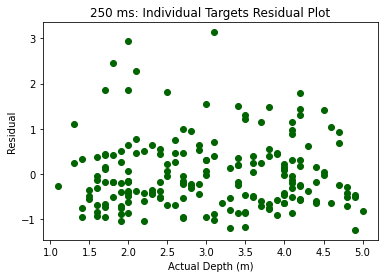

In [145]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_250).reshape(-1,1)
y = final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

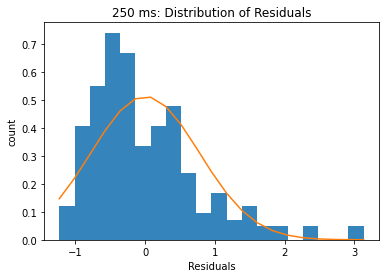

In [146]:
import scipy 
plt.title('250 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_250, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_250 = scipy.stats.norm.pdf(bins, mu_250, sigma)
plt.plot(bins, best_fit_line_250)

plt.show()

In [320]:
import scipy

# scipy.stats.pearsonr(yaw_250, residuals)

scipy.stats.pearsonr(pitch_250, residuals)

(0.051455954128312054, 0.41324819880112146)

slope: 0.500298    intercept: 1.376173
R-squared: 0.302393
Standard-error: 0.055128


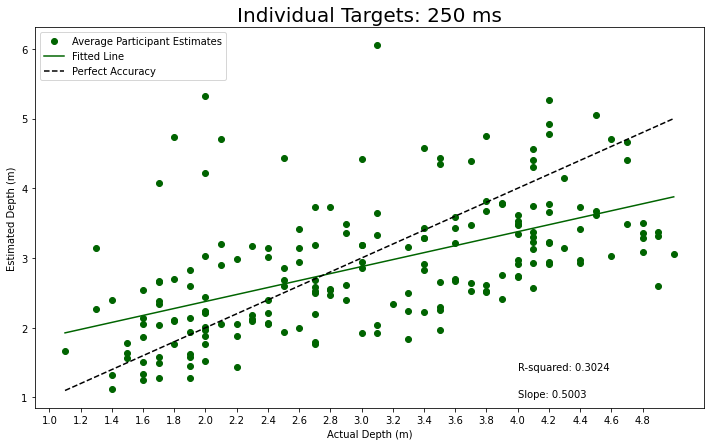

(0.5002976819969509,
 1.3761734412505855,
 0.5499031720478388,
 1.4442196410495854e-16,
 0.05512780808855646)

In [147]:
plot_img(stim_250, final_y_250, ste_250, 250)

slope: 0.002319    intercept: 0.586604
R-squared: 0.000022
Standard-error: 0.035874


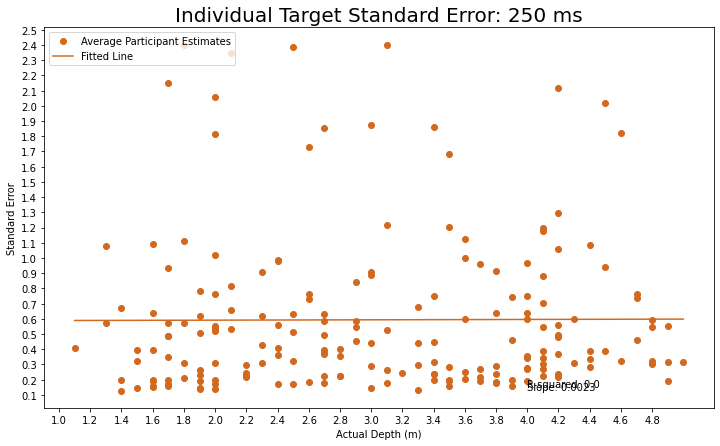

Average Standard Error 250 ms


0.593615880216337

In [148]:
plot_img_ste(stim_250, final_y_250, ste_250, 250)

avg_250 =np.mean(ste_250)
print("Average Standard Error 250 ms")
avg_250

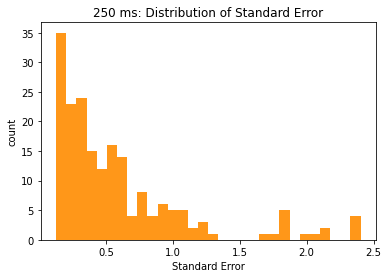

In [152]:
plt.hist(ste_250, bins=30, alpha=0.9, color = 'darkorange')
plt.title('250 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.023411    intercept: 3.797261
R-squared: 0.000055
Standard-error: 0.229194


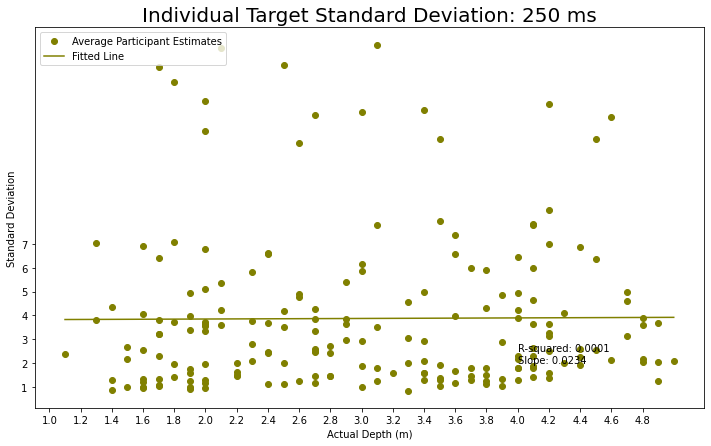

(0.023411009489891263,
 3.7972609438382037,
 0.0074101666578886794,
 0.9187493798123411,
 0.22919410385146807)

In [153]:
plot_img_std(stim_250, final_y_250, std_250, 250)

Look at images with standard errors on the tail of the distribution

In [710]:
high_ste_imgs_250 = [final_x_250[idx] for idx in range(len(ste_250)) if ste_250[idx] >= 0.7]
high_ste_imgs_250

['depth_duration_stimuli/003453_10/003453_10-target.png',
 'depth_duration_stimuli/002419_8/002419_8-target.png',
 'depth_duration_stimuli/003576_3/003576_3-target.png',
 'depth_duration_stimuli/003668_6/003668_6-target.png',
 'depth_duration_stimuli/000486_3/000486_3-target.png',
 'depth_duration_stimuli/003185_1/003185_1-target.png']

m: [0.62212088]
b: 1.0640246139082008
R-squared:  0.4263147335336126


Text(0, 0.5, 'Residual')

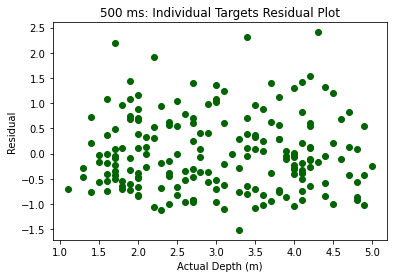

In [154]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_500).reshape(-1,1)
y = final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

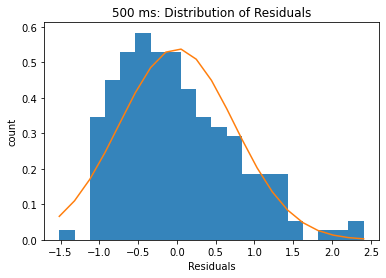

In [155]:
plt.title('500 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_500, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_500 = scipy.stats.norm.pdf(bins, mu_500, sigma)
plt.plot(bins, best_fit_line_500)

plt.show()

In [323]:
import scipy

# scipy.stats.pearsonr(yaw_500, residuals)

scipy.stats.pearsonr(pitch_500, residuals)

(0.12613464076655687, 0.04589540272286099)

slope: 0.622121    intercept: 1.064025
R-squared: 0.426315
Standard-error: 0.052356


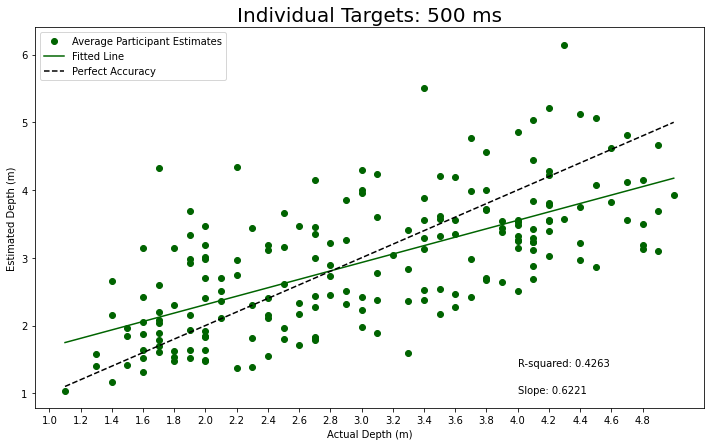

(0.6221208847245401,
 1.0640246139081995,
 0.6529278164802087,
 1.0426412677892262e-24,
 0.05235638559393593)

In [156]:
plot_img(stim_500, final_y_500, ste_500, 500)

slope: 0.043459    intercept: 0.425383
R-squared: 0.010789
Standard-error: 0.030190


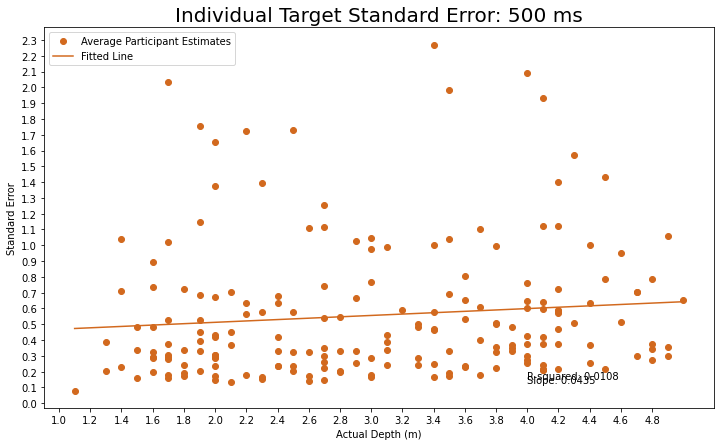

Average Standard Error 500 ms


0.5567797523583583

In [157]:
plot_img_ste(stim_500, final_y_500, ste_500, 500)

avg_500 =np.mean(ste_500)
print("Average Standard Error 500 ms")
avg_500

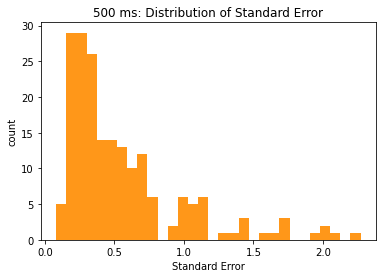

In [158]:
plt.hist(ste_500, bins=30, alpha=0.9, color = 'darkorange')
plt.title('500 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.280484    intercept: 2.832539
R-squared: 0.010304
Standard-error: 0.199430


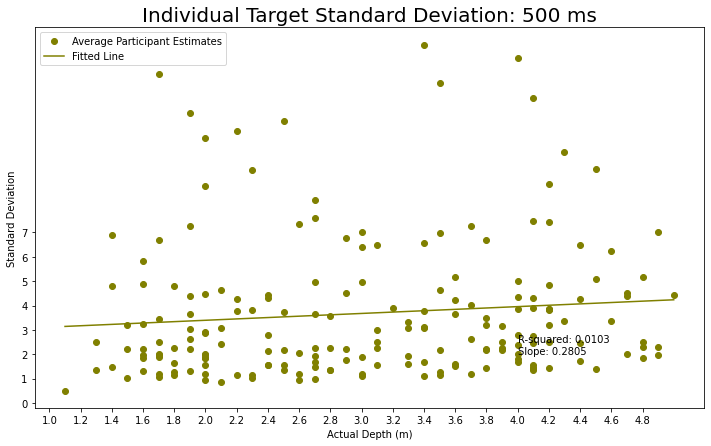

(0.28048435791231197,
 2.8325389870561177,
 0.10150637587067542,
 0.16122895799169165,
 0.19942956007780518)

In [159]:
plot_img_std(stim_500, final_y_500, std_500, 500)

Look at images with standard errors on the tail of the distribution

In [712]:
high_ste_imgs_500 = [final_x_500[idx] for idx in range(len(ste_500)) if ste_500[idx] >= 0.75]
high_ste_imgs_500

['depth_duration_stimuli/003351_1/003351_1-target.png',
 'depth_duration_stimuli/000689_9/000689_9-target.png']

m: [0.63642223]
b: 1.054981050201013
R-squared:  0.4461302935428003


Text(0, 0.5, 'Residual')

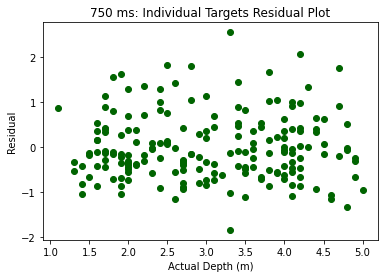

In [160]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_750).reshape(-1,1)
y = final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

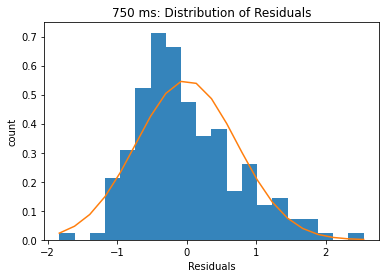

In [161]:
plt.title('750 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_750, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_750 = scipy.stats.norm.pdf(bins, mu_750, sigma)
plt.plot(bins, best_fit_line_750)

plt.show()

In [326]:
import scipy

# scipy.stats.pearsonr(yaw_750, residuals)

scipy.stats.pearsonr(pitch_750, residuals)

(0.07824749440981092, 0.21576659505392912)

slope: 0.636422    intercept: 1.054981
R-squared: 0.446130
Standard-error: 0.051445


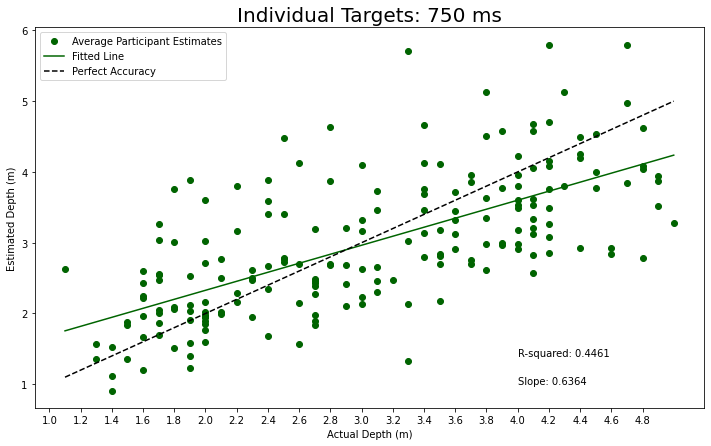

(0.6364222267409108,
 1.0549810502010113,
 0.6679298567535374,
 3.6159251183572044e-26,
 0.051444800502158355)

In [162]:
plot_img(stim_750, final_y_750, ste_750, 750)

slope: 0.025435    intercept: 0.484450
R-squared: 0.003457
Standard-error: 0.031328


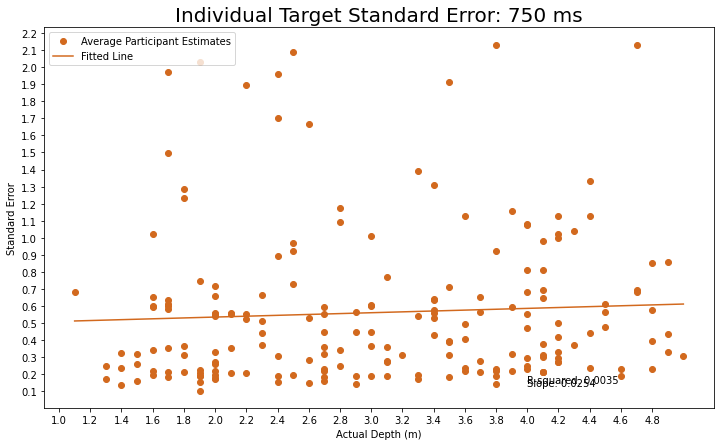

Average Standard Error 750 ms


0.5613495884299288

In [163]:
plot_img_ste(stim_750, final_y_750, ste_750, 750)

avg_750 =np.mean(ste_750)
print("Average Standard Error 750 ms")
avg_750

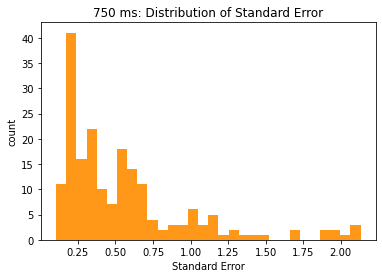

In [164]:
plt.hist(ste_750, bins=30, alpha=0.9, color = 'darkorange')
plt.title('750 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.162894    intercept: 3.219122
R-squared: 0.003235
Standard-error: 0.207430


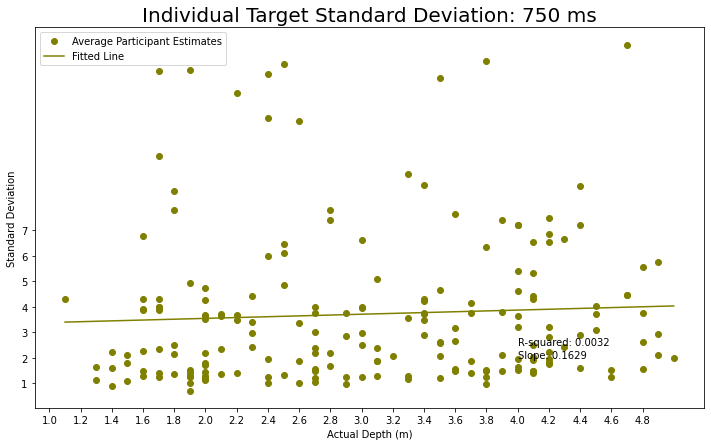

(0.1628941897696827,
 3.219122070140593,
 0.05687916400018875,
 0.43325787803832483,
 0.20743017160033614)

In [165]:
plot_img_std(stim_750, final_y_750, std_750, 750)

Look at images with standard errors on the tail of the distribution

In [719]:
high_ste_imgs_750 = [final_x_750[idx] for idx in range(len(ste_750)) if ste_750[idx] >= 0.75]
high_ste_imgs_750

['depth_duration_stimuli/003070_6/003070_6-target.png',
 'depth_duration_stimuli/002396_6/002396_6-target.png',
 'depth_duration_stimuli/002396_3/002396_3-target.png']

m: [0.60054091]
b: 1.126727057355618
R-squared:  0.4035110935193579


Text(0, 0.5, 'Residual')

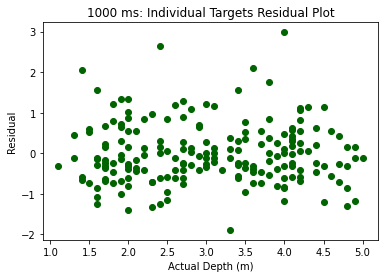

In [166]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

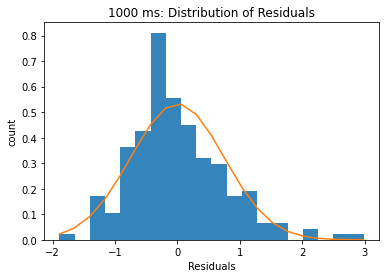

In [167]:
plt.title('1000 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_1000, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_1000 = scipy.stats.norm.pdf(bins, mu_1000, sigma)
plt.plot(bins, best_fit_line_1000)

plt.show()

In [329]:
import scipy

# scipy.stats.pearsonr(yaw_1000, residuals)

scipy.stats.pearsonr(pitch_1000, residuals)

(-0.01789744632862092, 0.7773889674115633)

slope: 0.600541    intercept: 1.126727
R-squared: 0.403511
Standard-error: 0.052971


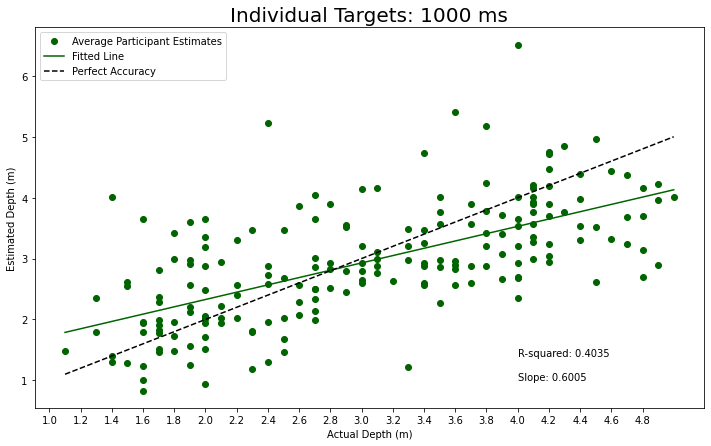

(0.6005409086619297,
 1.1267270573556174,
 0.6352252305437482,
 4.345171634098691e-23,
 0.05297113057479187)

In [168]:
plot_img(stim_1000, final_y_1000, ste_1000, 1000)

slope: -0.000987    intercept: 0.532072
R-squared: 0.000006
Standard-error: 0.030215


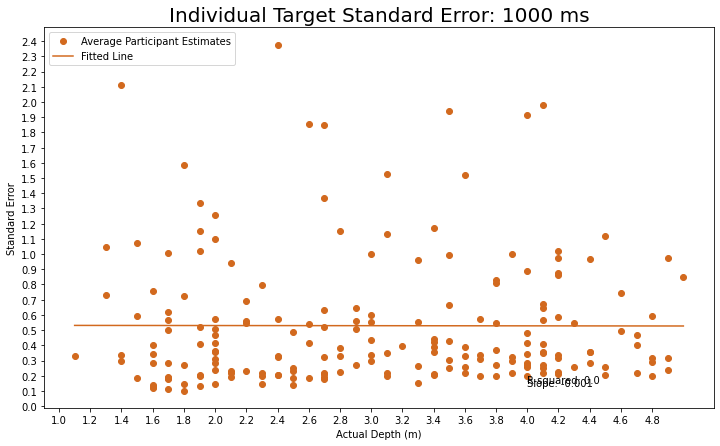

Average Standard Error 1000 ms


0.52908683624734

In [169]:
plot_img_ste(stim_1000, final_y_1000, ste_1000, 1000)

avg_1000 =np.mean(ste_1000)
print("Average Standard Error 1000 ms")
avg_1000

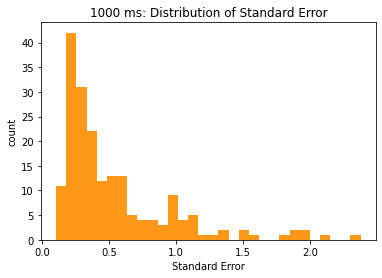

In [170]:
plt.hist(ste_1000, bins=30, alpha=0.9, color = 'darkorange')
plt.title('1000 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: -0.010758    intercept: 3.538020
R-squared: 0.000015
Standard-error: 0.199654


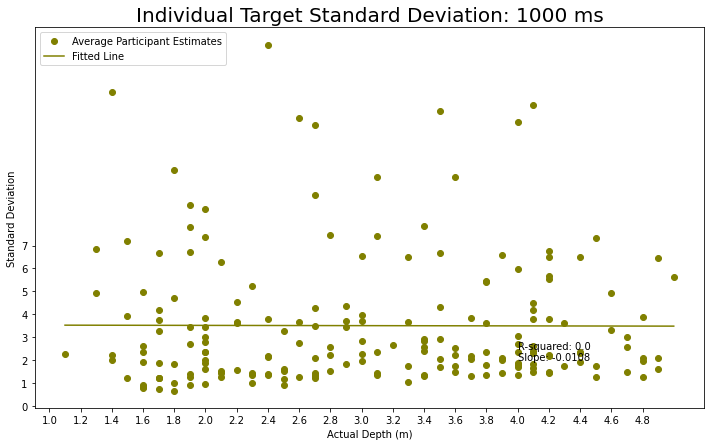

(-0.010757746916406356,
 3.5380197657729324,
 -0.003908985512748924,
 0.9570857434339887,
 0.19965359912202846)

In [171]:
plot_img_std(stim_1000, final_y_1000, std_1000, 1000)

Look at images with standard errors on the tail of the distribution

In [718]:
high_ste_imgs_1000 = [final_x_1000[idx] for idx in range(len(ste_1000)) if ste_1000[idx] >= 0.7]
high_ste_imgs_1000

['depth_duration_stimuli/001479_8/001479_8-target.png',
 'depth_duration_stimuli/002120_16/002120_16-target.png',
 'depth_duration_stimuli/000739_4/000739_4-target.png']

#### Summary Plots

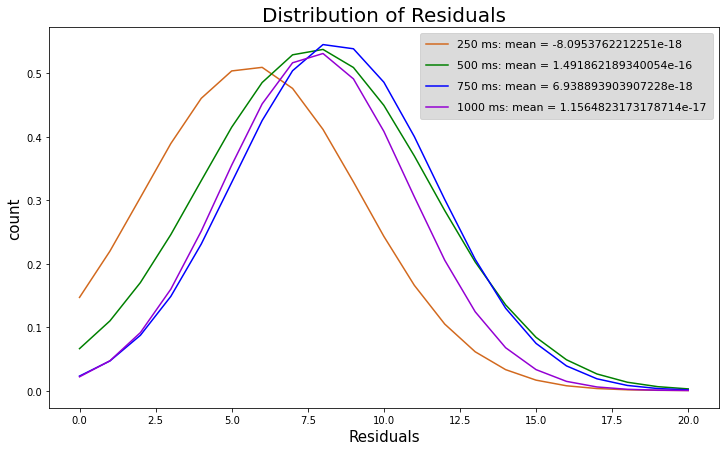

In [172]:
plt.figure(figsize = [12, 7])
plt.title('Distribution of Residuals', fontsize = 20)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('count', fontsize = 15)

plt.plot(best_fit_line_250, color = 'chocolate', label = '250 ms: '
        + 'mean = ' + str(mu_250))
plt.plot(best_fit_line_500, color = 'green', label = '500 ms: '
        + 'mean = ' + str(mu_500))
plt.plot(best_fit_line_750, color = 'blue', label = '750 ms: '
        + 'mean = ' + str(mu_750))
plt.plot(best_fit_line_1000, color = 'darkviolet', label = '1000 ms: '
        + 'mean = ' + str(mu_1000))

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#### Standard Deviation 

In [173]:
_250 = np.array(stim_250).reshape(1,-1)
avg_std_250 = np.std(_250[0])

_500 = np.array(stim_500).reshape(1,-1)
avg_std_500 = np.std(_500[0])

_750 = np.array(stim_750).reshape(1,-1)
avg_std_750 = np.std(_750[0])

_1000 = np.array(stim_1000).reshape(1,-1)
avg_std_1000 = np.std(_1000[0])


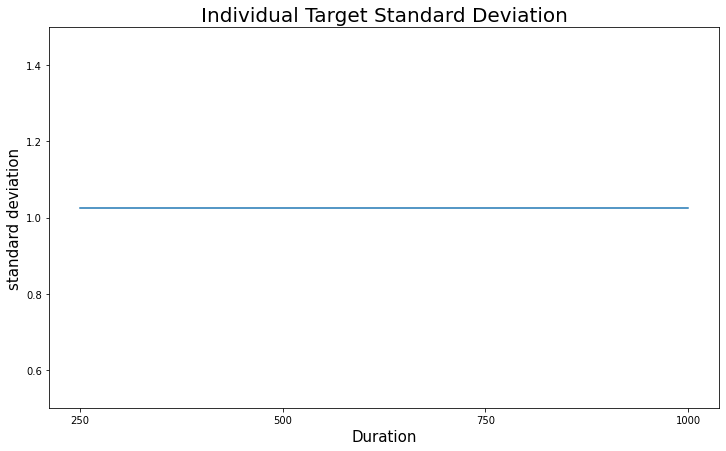

In [174]:
plt.figure(figsize = [12, 7])
plt.title('Individual Target Standard Deviation', fontsize = 20)
plt.xlabel('Duration', fontsize = 15)
plt.ylabel('standard deviation', fontsize = 15)
plt.ylim([0.5, 1.5])

durations = ['250', '500', '750', '1000']
stds = [avg_std_250, avg_std_500, avg_std_750, avg_std_1000]

plt.plot(durations, stds)

#### Sum of Abs Value of Individual Target Residuals from Identity Line (Perfect Accuracy) for each Duration Divided by the Number of Images

In [760]:
y_250_target_avgs = np.array(final_y_250)
perfect_accuracy_250 = np.array(stim_250)

#.reshape(-1,1)

residuals_250 = y_250_target_avgs - perfect_accuracy_250
abs_residuals_250 = np.absolute(residuals_250)
sum_residuals_250 = np.sum(abs_residuals_250)
(sum_residuals_250/len(stim_250)) 

0.8294219905854117

In [761]:
y_500_target_avgs = np.array(final_y_500)
perfect_accuracy_500 = np.array(stim_500)

#.reshape(-1,1)

residuals_500 = y_500_target_avgs - perfect_accuracy_500
abs_residuals_500 = np.absolute(residuals_500)
sum_residuals_500 = np.sum(abs_residuals_500)
(sum_residuals_500/len(stim_500)) 

0.8034776898821746

In [762]:
y_750_target_avgs = np.array(final_y_750)
perfect_accuracy_750 = np.array(stim_750)

#.reshape(-1,1)

residuals_750 = y_750_target_avgs - perfect_accuracy_750
abs_residuals_750 = np.absolute(residuals_750)
sum_residuals_750 = np.sum(abs_residuals_750)
(sum_residuals_750/len(stim_750)) 

0.7385407090912369

In [763]:
y_1000_target_avgs = np.array(final_y_1000)
perfect_accuracy_1000 = np.array(stim_1000)

#.reshape(-1,1)

residuals_1000 = y_1000_target_avgs - perfect_accuracy_1000
abs_residuals_1000 = np.absolute(residuals_1000)
sum_residuals_1000 = np.sum(abs_residuals_1000)
(sum_residuals_1000/len(stim_1000)) 

0.7192831202840149

#### Normalized data

In [293]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
normalized_trial_plot_data = trial_normalized_final
avg_average_particip_estim = 2.4779054712373956 # calculated above
##############################

n_final_x_250 = normalized_trial_plot_data[0][0]
n_final_y_250 = normalized_trial_plot_data[1][0]
n_ste_250 = normalized_trial_plot_data[2][0]
n_stim_250 = normalized_trial_plot_data[3][0]
n_std_250 = normalized_trial_plot_data[4][0]

n_final_x_500 = normalized_trial_plot_data[0][1]
n_final_y_500 = normalized_trial_plot_data[1][1]
n_ste_500 = normalized_trial_plot_data[2][1]
n_stim_500 = normalized_trial_plot_data[3][1]
n_std_500 = normalized_trial_plot_data[4][1]

n_final_x_750 = normalized_trial_plot_data[0][2]
n_final_y_750 = normalized_trial_plot_data[1][2]
n_ste_750 = normalized_trial_plot_data[2][2]
n_stim_750 = normalized_trial_plot_data[3][2]
n_std_750 = normalized_trial_plot_data[4][2]

n_final_x_1000 = normalized_trial_plot_data[0][3]
n_final_y_1000 = normalized_trial_plot_data[1][3]
n_ste_1000 = normalized_trial_plot_data[2][3]
n_stim_1000 = normalized_trial_plot_data[3][3]
n_std_1000 = normalized_trial_plot_data[4][3]

In [771]:
kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x --> calculate tilt 

n_yaw_250 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_250]
n_yaw_500 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_500]
n_yaw_750 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_750]
n_yaw_1000 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_1000]

In [772]:
def normalized_plot_img(actualdepth, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actualdepth)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.5, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.7, text_r2) 
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = "Individual Targets: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "darkgreen")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "darkgreen")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x/avg, label = "Perfect Accuracy Normalized", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [301]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normalized_plot_img_std(actual_depth, y, std, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(std) # STD not Y 
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 1, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 1.5, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 8, step = 1))
    plt.title(label = "Normalized: Individual Target Standard Deviation: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Deviation")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "mediumslateblue")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "mediumslateblue")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

m: [0.14195391]
b: 0.545439868423234
R-squared:  0.42702148884339397


Text(0, 0.5, 'Residual')

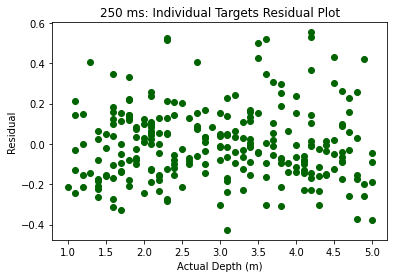

In [773]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(n_stim_250).reshape(-1,1)
y = n_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

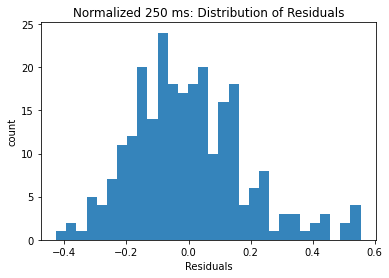

In [774]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 250 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [775]:
import scipy

scipy.stats.pearsonr(n_yaw_250, residuals)

(0.013749745780135198, 0.8270415655140378)

slope: 0.141954    intercept: 0.545440
R-squared: 0.427021
Standard-error: 0.010338


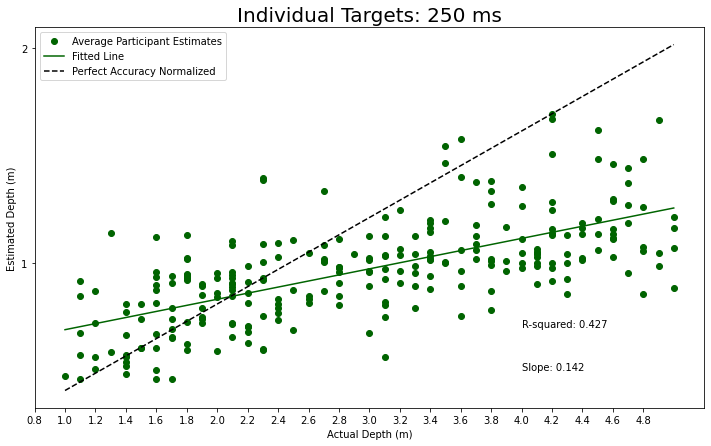

In [776]:
slope_250 = normalized_plot_img(n_stim_250, n_final_y_250, n_ste_250, 250,
                                       avg_average_particip_estim)[0]

slope: 0.004544    intercept: 0.080984
R-squared: 0.007718
Standard-error: 0.003240


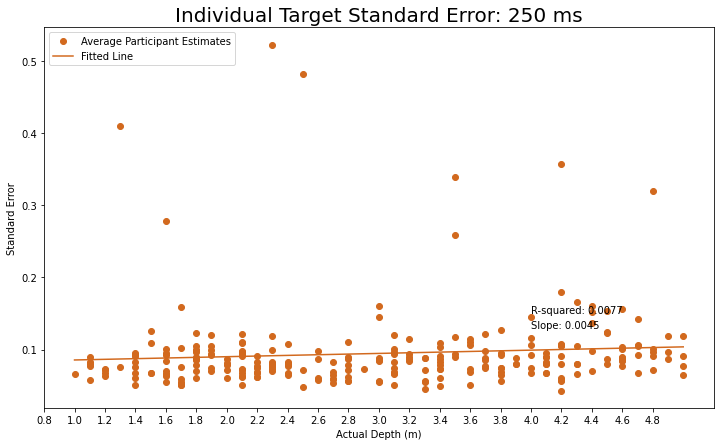

Normalized: Average Standard Error 250 ms


0.09450682049655054

In [777]:
slope_250 = plot_img_ste(n_stim_250, n_final_y_250, n_ste_250, 250)[0]

avg_250 =np.mean(n_ste_250)
print("Normalized: Average Standard Error 250 ms")
avg_250

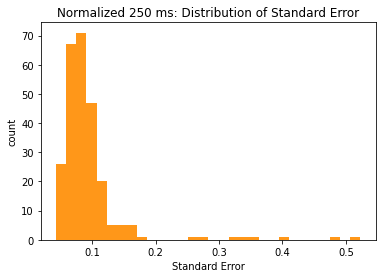

In [778]:
plt.hist(n_ste_250, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 250 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.018730    intercept: 0.371581
R-squared: 0.006569
Standard-error: 0.014480


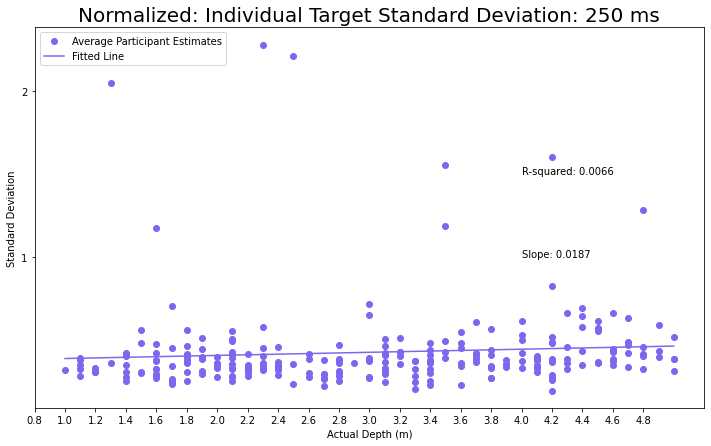

(0.018729783237065242,
 0.3715812729543456,
 0.08105229322997788,
 0.19702778236146018,
 0.01448024580172383)

In [302]:
normalized_plot_img_std(n_stim_250, n_final_y_250, n_std_250, 250)

m: [0.17760956]
b: 0.46267166282027594
R-squared:  0.4182753667821384


Text(0, 0.5, 'Residual')

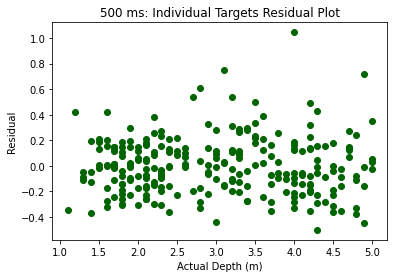

In [779]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(n_stim_500).reshape(-1,1)
y = n_final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

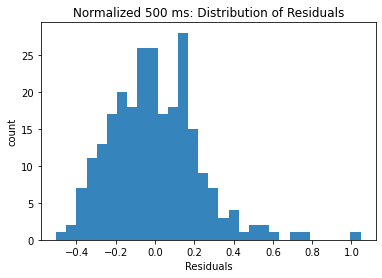

In [780]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 500 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [781]:
import scipy

scipy.stats.pearsonr(n_yaw_500, residuals)

(0.060919627445499405, 0.3364395878061795)

slope: 0.177610    intercept: 0.462672
R-squared: 0.418275
Standard-error: 0.013274


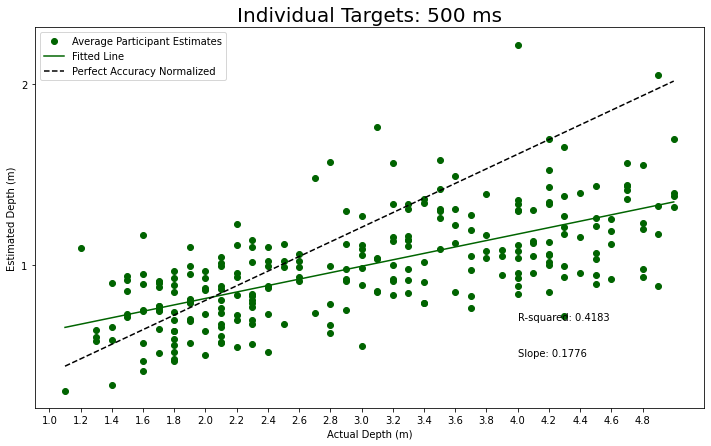

In [782]:
slope_500 = normalized_plot_img(n_stim_500, n_final_y_500, n_ste_500, 500,
                                       avg_average_particip_estim)[0]


slope: 0.013606    intercept: 0.050842
R-squared: 0.084614
Standard-error: 0.002836


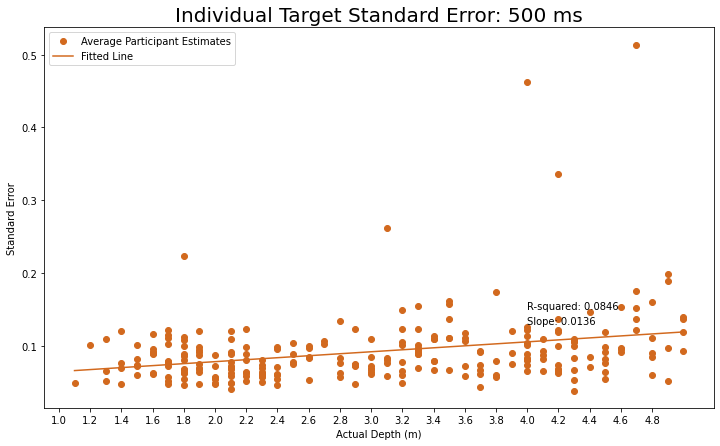

Normalized: Average Standard Error 500 ms


0.09169162670688313

In [783]:
slope_500 = plot_img_ste(n_stim_500, n_final_y_500, n_ste_500, 500)[0]

avg_500 =np.mean(n_ste_500)
print("Normalized: Average Standard Error 500 ms")
avg_500

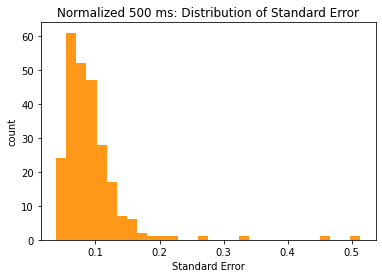

In [784]:
plt.hist(n_ste_500, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 500 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.063612    intercept: 0.227927
R-squared: 0.083681
Standard-error: 0.013340


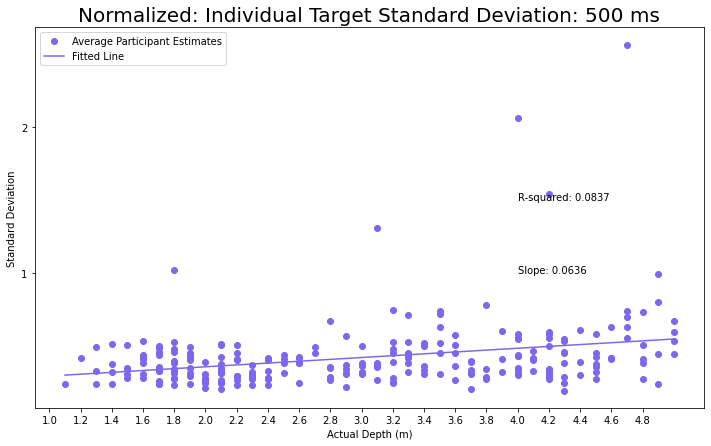

(0.06361213025985822,
 0.22792676845627463,
 0.2892771197921517,
 3.1597461394132527e-06,
 0.013339804580296545)

In [303]:
normalized_plot_img_std(n_stim_500, n_final_y_500, n_std_500, 500)

m: [0.21430492]
b: 0.3775883232696592
R-squared:  0.5540344631882208


Text(0, 0.5, 'Residual')

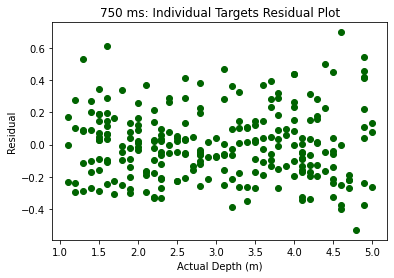

In [786]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(n_stim_750).reshape(-1,1)
y = n_final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

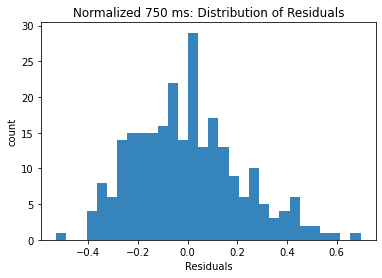

In [787]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 750 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [788]:
import scipy

scipy.stats.pearsonr(n_yaw_750, residuals)

(0.04929747760710292, 0.43588760792695036)

slope: 0.214305    intercept: 0.377588
R-squared: 0.554034
Standard-error: 0.012160


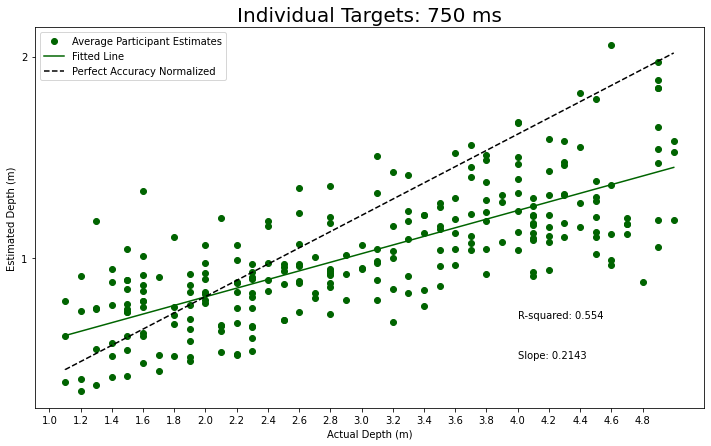

In [789]:
slope_750 = normalized_plot_img(n_stim_750, n_final_y_750, n_ste_750, 750,
                                       avg_average_particip_estim)[0]


slope: 0.011756    intercept: 0.057086
R-squared: 0.077240
Standard-error: 0.002570


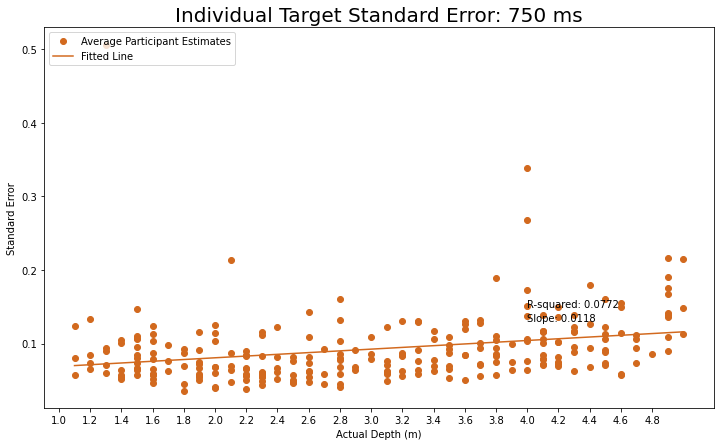

Normalized: Average Standard Error 750 ms


0.09241842558201646

In [790]:
slope_750 = plot_img_ste(n_stim_750, n_final_y_750, n_ste_750, 750)[0]

avg_750 =np.mean(n_ste_750)
print("Normalized: Average Standard Error 750 ms")
avg_750

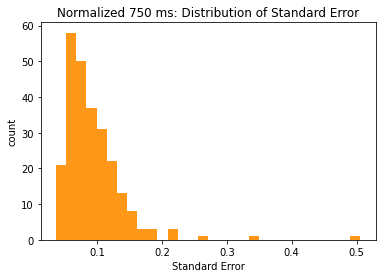

In [791]:
plt.hist(n_ste_750, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 750 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.054892    intercept: 0.257376
R-squared: 0.081595
Standard-error: 0.011647


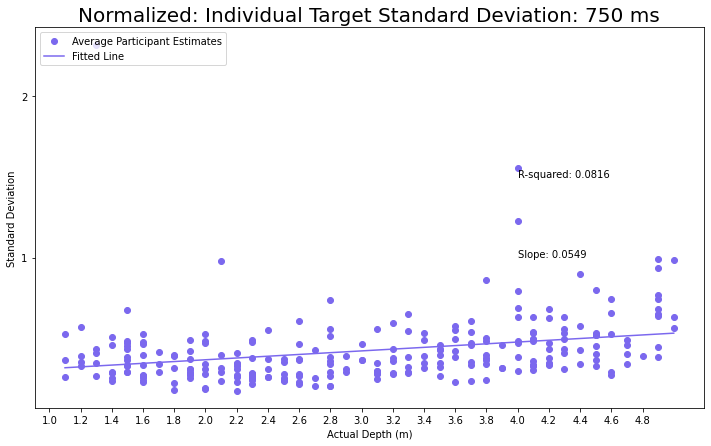

(0.054892109692419117,
 0.25737589681716777,
 0.2856483977314141,
 4.058557252401345e-06,
 0.011647299520952791)

In [304]:
normalized_plot_img_std(n_stim_750, n_final_y_750, n_std_750, 750)

m: [0.52860322]
b: 0.9307801862166636
R-squared:  0.48980436206217637


Text(0, 0.5, 'Residual')

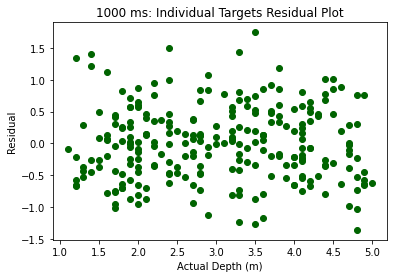

In [793]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

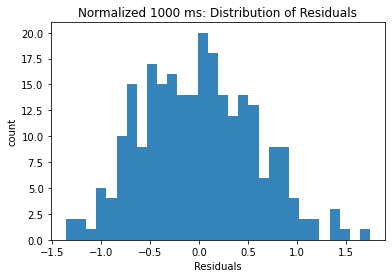

In [794]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 1000 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [795]:
import scipy

scipy.stats.pearsonr(n_yaw_1000, residuals)

(-0.041146087202661816, 0.5155617893937503)

slope: 0.222830    intercept: 0.338165
R-squared: 0.550703
Standard-error: 0.012730


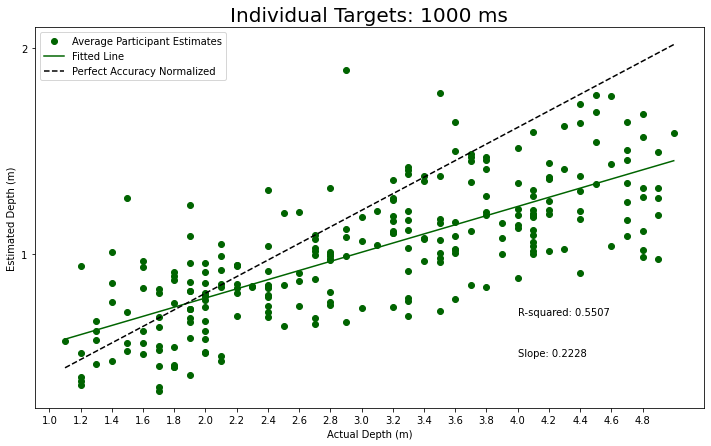

In [796]:
slope_1000 = normalized_plot_img(n_stim_1000, n_final_y_1000, n_ste_1000, 1000,
                                       avg_average_particip_estim)[0]

slope: 0.009604    intercept: 0.062872
R-squared: 0.038974
Standard-error: 0.003016


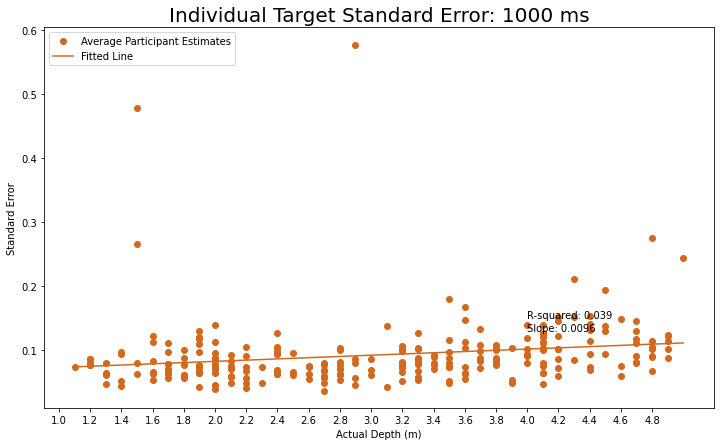

Normalized: Average Standard Error 1000 ms


0.09194229651912776

In [797]:
slope_1000 = plot_img_ste(n_stim_1000, n_final_y_1000, n_ste_1000, 1000)[0]

avg_100 =np.mean(n_ste_1000)
print("Normalized: Average Standard Error 1000 ms")
avg_100

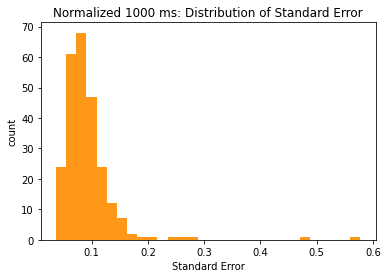

In [798]:
plt.hist(n_ste_1000, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 1000 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

In [769]:
avg_average_particip_estim

2.4779054712373956

slope: 0.044155    intercept: 0.285737
R-squared: 0.040093
Standard-error: 0.013664


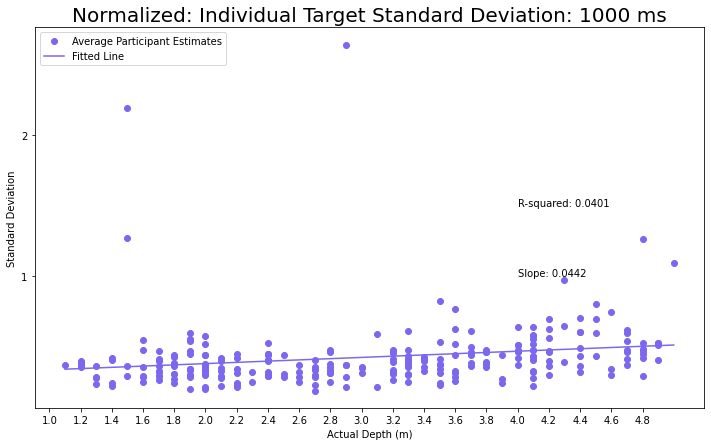

(0.04415511394558072,
 0.28573672357596236,
 0.2002328352075995,
 0.0013972675193088706,
 0.013664389892209361)

In [305]:
normalized_plot_img_std(n_stim_1000, n_final_y_1000, n_std_1000, 1000)

#### Standard Deviation 

In [254]:
n_250 = np.array(n_stim_250).reshape(1,-1)
n_std_250 = np.std(n_250[0])

n_500 = np.array(n_stim_500).reshape(1,-1)
n_std_500 = np.std(n_500[0])

n_750 = np.array(n_stim_750).reshape(1,-1)
n_std_750 = np.std(n_750[0])

n_1000 = np.array(n_stim_1000).reshape(1,-1)
n_std_1000 = np.std(n_1000[0])


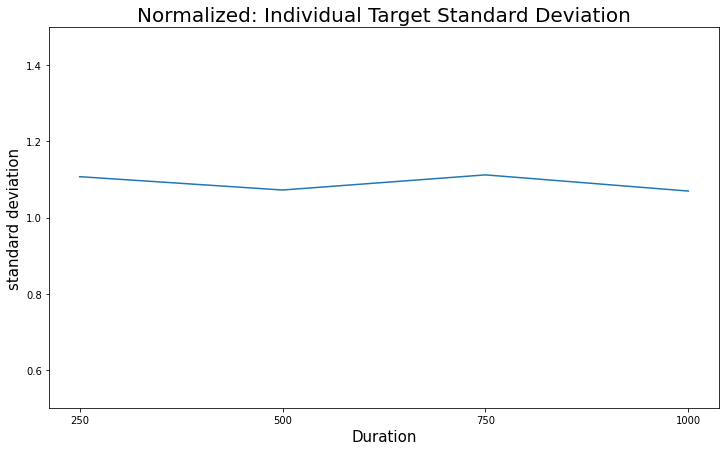

In [259]:
plt.figure(figsize = [12, 7])
plt.title('Normalized: Individual Target Standard Deviation', fontsize = 20)
plt.xlabel('Duration', fontsize = 15)
plt.ylabel('standard deviation', fontsize = 15)
plt.ylim([0.5, 1.5])

durations = ['250', '500', '750', '1000']
stds = [n_std_250, n_std_500, n_std_750, n_std_1000]

plt.plot(durations, stds)

#### Sum of Abs Value of Individual Target Residuals from Identity Line (Perfect Accuracy) for each Duration Divided by the Number of Images, Multiplied by Avg Depth Estimation

In [765]:
n_y_250_target_avgs = np.array(n_final_y_250)
n_perfect_accuracy_250 = np.array(n_stim_250)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_250 = n_y_250_target_avgs - n_perfect_accuracy_250
n_abs_residuals_250 = np.absolute(n_residuals_250)
n_sum_residuals_250 = np.sum(n_abs_residuals_250)
avg_average_particip_estim * (n_sum_residuals_250/len(n_stim_250))

0.8059772371117145

In [766]:
n_y_500_target_avgs = np.array(n_final_y_500)
n_perfect_accuracy_500 = np.array(n_stim_500)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_500 = n_y_500_target_avgs - n_perfect_accuracy_500
n_abs_residuals_500 = np.absolute(n_residuals_500)
n_sum_residuals_500 = np.sum(n_abs_residuals_500)
avg_average_particip_estim * (n_sum_residuals_500/len(n_stim_500))

0.7708876596510049

In [767]:
n_y_750_target_avgs = np.array(n_final_y_750)
n_perfect_accuracy_750 = np.array(n_stim_750)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_750 = n_y_750_target_avgs - n_perfect_accuracy_750
n_abs_residuals_750 = np.absolute(n_residuals_750)
n_sum_residuals_750 = np.sum(n_abs_residuals_750)
avg_average_particip_estim * (n_sum_residuals_750/len(n_stim_750))

0.7033848187286228

In [768]:
n_y_1000_target_avgs = np.array(n_final_y_1000)
n_perfect_accuracy_1000 = np.array(n_stim_1000)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_1000 = n_y_1000_target_avgs - n_perfect_accuracy_1000
n_abs_residuals_1000 = np.absolute(n_residuals_1000)
n_sum_residuals_1000 = np.sum(n_abs_residuals_1000)
avg_average_particip_estim * (n_sum_residuals_1000/len(n_stim_1000))

0.6913777951075661

## Split data randomly into half: Correlate Residuals

In [306]:
import random
from sklearn.linear_model import LinearRegression
import scipy
from scipy import stats 

def get_stimuli(data):
    """
    Args:
        data = [df_250, df_500, df_750, df_1000]
    Returns:
        all_stimuli = [imgs_250, imgs_500, imgs_750, imgs_1000]
    """
    
    all_stimuli = []
    for df in data:
        stimuli = set()
        for idx, row in df.iterrows():
            stimulus = row["stimulus"]
            stimuli.add(stimulus)
        all_stimuli.append(list(stimuli))
        
    return all_stimuli

def split_correlations(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 

    """
    
    stimuli = get_stimuli(data)
    splits = [None, None, None, None]
    duration_split_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        splits[i] = [split1[0], split2[0]]
        
        duration_split_corrs[i] = scipy.stats.pearsonr(split1[0], split2[0])[0] 

    
    return duration_split_corrs # raw splits 

def split_std_error(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        Avg of the split standard errors for each duration 

    """
    
    stimuli = get_stimuli(data)
    stderrors = [None, None, None, None]
    duration_avg_stderr = [None, None, None, None ]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):
                                                               int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        split1_stderr = stats.sem(split1[0])
        split2_stderr = stats.sem(split2[0])

        stderrors[i] = [split1_stderr, split2_stderr]
        
        duration_avg_stderr[i] = np.mean(stderrors[i])
        

    return duration_avg_stderr


def split_std(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        Avg of the split standard deviations for each duration 

    """
    
    stimuli = get_stimuli(data)
    stds = [None, None, None, None]
    duration_avg_std = [None, None, None, None ]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):
                                                               int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        split1_std = np.std(split1[0])
        split2_std = np.std(split2[0])

        stds[i] = [split1_std, split2_std]
        
        duration_avg_std[i] = np.mean(stds[i])
        

    return duration_avg_std

def split_residuals(data, proportion, duration, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
        
    Dataframs is computationally expensive --> extract raw data and compute operations within functions using np.array
    declare numpy array --> add to that 
    --> once next sequence is set you can declare a numpy array of the size 256 (number of images)
    """
    
    stimuli = get_stimuli(data)
    duration_residual_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list   
        
        duration_residual_corrs[i] = scipy.stats.pearsonr(split1_residuals[0], split2_residuals[0])[0] 
        
        if i == duration: 
            return stim_actual, split1_residuals, split2_residuals
        


def split_residual_correlations(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
        
    Dataframs is computationally expensive --> extract raw data and compute operations within functions using np.array
    declare numpy array --> add to that 
    --> once next sequence is set you can declare a numpy array of the size 256 (number of images)
    """
    
    stimuli = get_stimuli(data)
    
    duration_residual_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list                                
        duration_residual_corrs[i] = scipy.stats.pearsonr(split1_residuals[0], split2_residuals[0])[0] 
        

    return duration_residual_corrs

def generate_n_split_correlations(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON REGRESSION CORRELATIONS
    """

    corrs = np.array([split_residual_correlations(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(corrs, axis = 0) 
    return corrs, mean

def generate_n_raw_split_correlations(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON RAW SPLITS 
    """

    corrs = np.array([split_correlations(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(corrs, axis = 0) 
    return corrs, mean

def generate_n_split_std_error(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON STD ERROR AVGS
    """

    avgs = np.array([split_std_error(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(avgs, axis = 0) 
    return avgs, mean


def generate_n_split_std(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON STD AVGS
    """

    avgs = np.array([split_std(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(avgs, axis = 0) 
    return avgs, mean
              

In [195]:
from sklearn.metrics import r2_score

def split_residual_rsquare(data, proportion, normalize = False, avg_participant_estimate = None):
    
    stimuli = get_stimuli(data)
    
    duration_residual_r2 = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list                                
        duration_residual_r2[i] = r2_score(split1_residuals[0], split2_residuals[0])
        

    return duration_residual_r2

def generate_n_split_r2(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON SPLIT RESIDUAL R^2
    """

    residual_r2s = np.array([split_residual_rsquare(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(residual_r2s, axis = 0) 
    return residual_r2s, mean

#### Split Residual R-Squared 

In [190]:
r2_100_05 = generate_n_split_r2(100, cleaned_data, 0.5)
r2_100_04 = generate_n_split_r2(100, cleaned_data, 0.4)
r2_100_03 = generate_n_split_r2(100, cleaned_data, 0.3)
r2_100_02 = generate_n_split_r2(100, cleaned_data, 0.2)

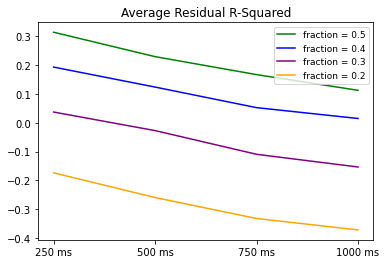

In [191]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

In [192]:
avg_average_particip_estim = 2.4779054712373956

In [194]:
norm_r2_100_05 = generate_n_split_std_error(100, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
norm_r29_100_04 = generate_n_split_std_error(100, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
norm_r2_100_03 = generate_n_split_std_error(100, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
norm_r2_100_02 = generate_n_split_std_error(100, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

In [ ]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

#### Correlation between the splits: non-normalized data 

In [145]:
splits_05 = generate_n_raw_split_correlations(100, cleaned_data, 0.5)
splits_04 = generate_n_raw_split_correlations(100, cleaned_data, 0.4)
splits_03 = generate_n_raw_split_correlations(100, cleaned_data, 0.3)
splits_02 = generate_n_raw_split_correlations(100, cleaned_data, 0.2)


In [149]:
norm_splits_05 = generate_n_raw_split_correlations(100, normalized_cleaned_data, 0.5)
norm_splits_04 = generate_n_raw_split_correlations(100, normalized_cleaned_data, 0.4)
norm_splits_03 = generate_n_raw_split_correlations(100, normalized_cleaned_data, 0.3)
norm_splits_02 = generate_n_raw_split_correlations(100, normalized_cleaned_data, 0.2)


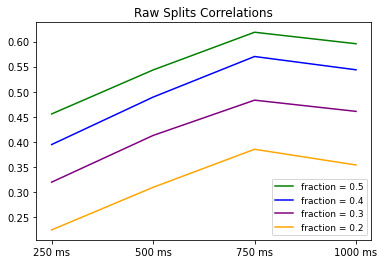

In [147]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, splits_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, splits_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, splits_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, splits_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Raw Splits Correlations')
plt.legend(fontsize = 9)
plt.show()

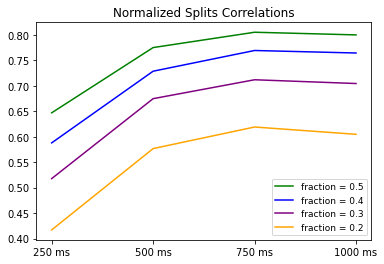

In [150]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_splits_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_splits_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_splits_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_splits_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized Splits Correlations')
plt.legend(fontsize = 9)
plt.show()

### Avg standard error of splits 

In [168]:
ste_100_05 = generate_n_split_std_error(100, cleaned_data, 0.5)
ste_100_04 = generate_n_split_std_error(100, cleaned_data, 0.4)
ste_100_03 = generate_n_split_std_error(100, cleaned_data, 0.3)
ste_100_02 = generate_n_split_std_error(100, cleaned_data, 0.2)

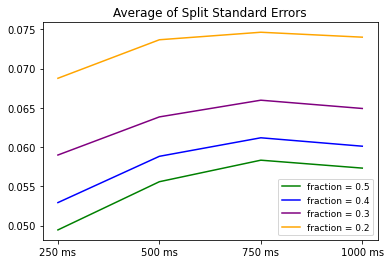

In [170]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, ste_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, ste_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, ste_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, ste_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average of Split Standard Errors')
plt.legend(fontsize = 9)
plt.show()

In [171]:
norm_ste_100_05 = generate_n_split_std_error(100, normalized_cleaned_data, 0.5)
norm_ste_100_04 = generate_n_split_std_error(100, normalized_cleaned_data, 0.4)
norm_ste_100_03 = generate_n_split_std_error(100, normalized_cleaned_data, 0.3)
norm_ste_100_02 = generate_n_split_std_error(100, normalized_cleaned_data, 0.2)

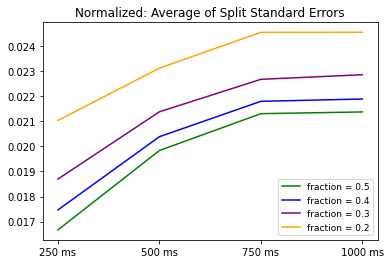

In [172]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_ste_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_ste_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_ste_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_ste_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average of Split Standard Errors')
plt.legend(fontsize = 9)
plt.show()

### Avg standard deviation of splits 

In [307]:
std_100_05 = generate_n_split_std(10, cleaned_data, 0.5)
std_100_04 = generate_n_split_std(10, cleaned_data, 0.4)
std_100_03 = generate_n_split_std(10, cleaned_data, 0.3)
std_100_02 = generate_n_split_std(10, cleaned_data, 0.2)

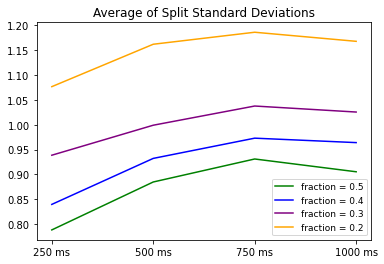

In [308]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, std_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, std_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, std_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, std_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average of Split Standard Deviations')
plt.legend(fontsize = 9)
plt.show()

In [ ]:
norm_std_100_05 = generate_n_split_std(100, normalized_cleaned_data, 0.5)
norm_std_100_04 = generate_n_split_std(100, normalized_cleaned_data, 0.4)
norm_std_100_03 = generate_n_split_std(100, normalized_cleaned_data, 0.3)
norm_std_100_02 = generate_n_split_std(100, normalized_cleaned_data, 0.2)

In [ ]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_std_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_std_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_std_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_std_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average of Split Standard Deviations')
plt.legend(fontsize = 9)
plt.show()

### Correlation between the residuals of splits

In [ ]:
raw_100_05 = generate_n_split_correlations(100, cleaned_data, 0.5)
raw_100_04 = generate_n_split_correlations(100, cleaned_data, 0.4)
raw_100_03 = generate_n_split_correlations(100, cleaned_data, 0.3)
raw_100_02 = generate_n_split_correlations(100, cleaned_data, 0.2)

In [ ]:
# raw_10000_05 = generate_n_split_correlations(10000, cleaned_data, 0.5)
# raw_10000_04 = generate_n_split_correlations(10000, cleaned_data, 0.4)
# raw_10000_03 = generate_n_split_correlations(10000, cleaned_data, 0.3)
# raw_10000_02 = generate_n_split_correlations(10000, cleaned_data, 0.2)

In [107]:
avg_average_particip_estim = 2.4779054712373956

In [113]:
normalized_100_05 = generate_n_split_correlations(100, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
normalized_100_04 = generate_n_split_correlations(100, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
normalized_100_03 = generate_n_split_correlations(100, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
normalized_100_02 = generate_n_split_correlations(100, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

In [ ]:
# normalized_10000_05 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
# normalized_10000_04 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
# normalized_10000_03 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
# normalized_10000_02 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

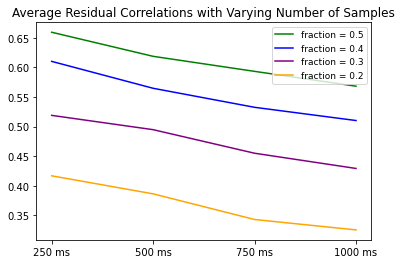

In [122]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, raw_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, raw_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, raw_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, raw_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual Correlations with Varying Number of Samples')
plt.legend(fontsize = 9)
plt.show()

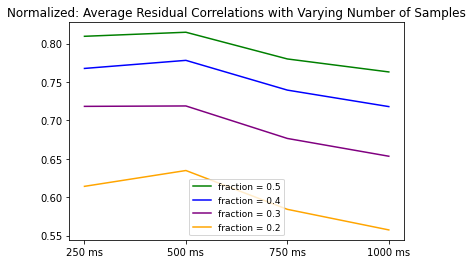

In [114]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, normalized_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, normalized_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, normalized_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, normalized_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual Correlations with Varying Number of Samples')
plt.legend(fontsize = 9)
plt.show()

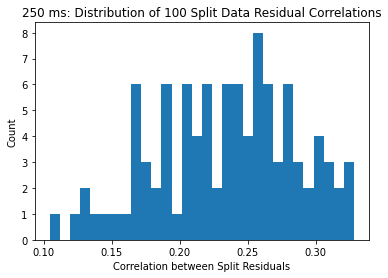

0.23373248798972746


In [286]:
lst_100_split_250_corrs = [elem[0] for elem in raw_100_05[0]]

plt.hist(lst_100_split_250_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'250 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_250_corrs)))

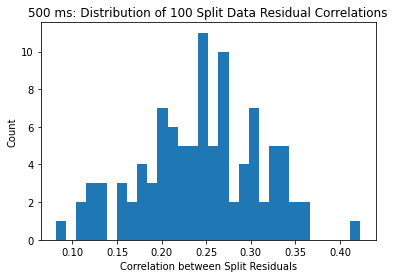

0.24456522832811065


In [285]:
lst_100_split_500_corrs = [elem[1] for elem in raw_100_05[0]]

plt.hist(lst_100_split_500_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'500 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_500_corrs)))

In [92]:
# lst_100_split_750_corrs = [elem[2] for elem in raw_100_05[0]]

# plt.hist(split1_750ms_05_n1, density = False, bins=30)
# plt.xlabel('Correlation between Split Residuals')
# plt.ylabel('Count')
# plt.title(r'750 ms: Distribution of 100 Split Data Residual Correlations')
# plt.show()

# print(np.mean(np.array(lst_100_split_750_corrs)))

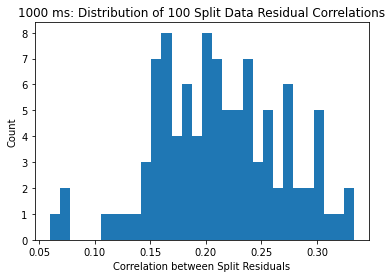

0.21255502738709686


In [283]:
lst_100_split_1000_corrs = [elem[3] for elem in raw_100_05[0]]

plt.hist(lst_100_split_1000_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'1000 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_1000_corrs)))

#### Plot Split Residuals 

In [85]:
# split residuals for 750ms with fraction = 0.5, for n=1 where n is the number of iterations

actual_750ms_05_n1, split1_750ms_05_n1, split2_750ms_05_n1 = split_residuals(cleaned_data, 0.5, 2)

Text(0, 0.5, 'Split 2 Residuals')

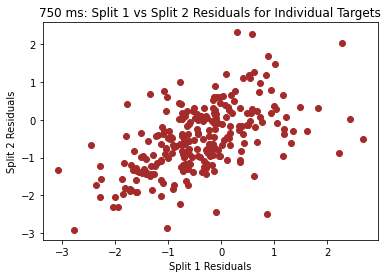

In [86]:
plt.plot(split1_750ms_05_n1,split2_750ms_05_n1, 'o', color='brown')
plt.title("750 ms: Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

In [105]:
norm_actual_750ms_05_n1, norm_split1_750ms_05_n1, norm_split2_750ms_05_n1 = split_residuals(normalized_cleaned_data, 0.5, 2, True, avg_average_particip_estim)

Text(0, 0.5, 'Split 2 Residuals')

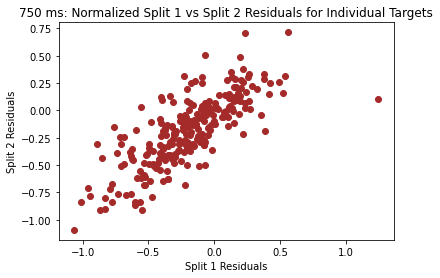

In [106]:
plt.plot(norm_split1_750ms_05_n1,norm_split2_750ms_05_n1, 'o', color='brown')
plt.title("750 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")